# Spec2Vec - spectra networking
The aim of Spec2Vec is to represent each spectrum by an abstract, low-dimensional (typically 200-500 dimensional) vector which is able to capture the underlying molecular relationships between spectra.

One of the important envisioned use-cases for the Spec2Vec based spectra similarity measure, is **molecular networking**. Here we aim at clustering all spectra by building networks from nodes (=spectra) and their most prominent edges/connections (=most similar pairs of spectra).


## Notebook outline
0. Importing folders and packages
1. Import and filter MS-MS data from MGF file
2. Build networks...

In [1]:
# Locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_SPEC2VEC = ROOT + "\\Spec2Vec\\code\\"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_MODEL = ROOT + "\\Spec2Vec\\models_trained\\"
PATH_COMPUTED = ROOT + "\\Spec2Vec\\computed_results\\"
PATH_OUTPUT = ROOT + "\\Spec2Vec\\output_plots\\"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import sys
sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions

# 1. Import and filter MS-MS data from MGF file

### Loading MGF file
In the following the MGF file containing all spectra and metadata will be loaded. 
The MGF file was generated from all publich gnps libraries (state: 26 July 2019). Spectra annotations were checked, cleaned, and extended where possible following a procedure described in another notebook: https://github.com/iomega/Spec2Vec/blob/master/notebooks/Spec2Vec_01_MGF_from_gnps_library_search.ipynb  

### Spectra filtering
#### 1. Discard spectra with too few peaks.
Spectra with less than "min_peaks" peaks will be ignored. Here this is set to min_peaks = 10.  

#### 2. Filter out noise. 
This can be done by:
#### A) Exponential peak intensity filter 
Further filtering is done to reduce the level of noise in the spectra. For this we calculate a threshold (or minimum peak intensity) for every spectrum. Where possible (most cases), this threshold is calculated by doing an exponential fit to the peak intensity histogram ("exp_intensity_filter"). If that fails we take the mean intensity of all peaks but the highest as a threshold.  
**But keep enough information:** Aimed at similar sized documents: If the number of peaks above the set threshold is lower than $n_{aim}$ = min_peaks + peaks_per_mz * precursor_mass we will at least keep the highest $n_{aim}$ peaks.

#### B) Relative peak intensity filter
This is a simpler filter which will discard all peaks with an intensity < min_intensity_perc/100 * max_peak_intensity.

### Creation of documents from spectra
Peaks and losses (= precursor mass - peak mass) are converted into words using a precision of "num_decimals".  
A peak with m/z = 108.3643 will hence become a string: "peak_108.36".  
A loss with m/z = 64.2257 will hence become a string: "loss_64.23".  
All words of one spectrum are collected in one list which represents the entire spectrum as a 'document'.

In [3]:
file_json = PATH_MS_DATA + "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json"
file_mgf = PATH_MS_DATA + "MS-MS_spectra_GNPS_cleaned_positive_mode_spectra_uniqueInchikey_subset.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [4]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10998


# 2. Load model and find most similar spectra

### Switch to Spec2Vec core functionality

In [5]:
# Import Spec2Vec functions
from similarity_measure import SimilarityMeasures
from plotting_functions import plot_precentile
import MS_similarity_classical as MS_sim_classic

# Import additional functions
from scipy import spatial

### Create SimilarityMeasures object

In [6]:
MS_library = SimilarityMeasures(MS_documents, MS_documents_intensity)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

Preprocess documents...
Number of unique words:  116344


### Load pretrained Spec2Vec model

In [7]:
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_uniqueInchikey_pos_d300_w500_neg5_minmax10_1000_dec2_exp08_iter100_TEMP_15.model'
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [15], 
                             use_stored_model=True)

Load stored word2vec model ...


In [8]:
MS_library.get_vectors_centroid(method = 'ignore', 
                                 tfidf_weighted = False, 
                                 weighting_power = 0.5, 
                                 tfidf_model = None,
                                 extra_epochs = 1)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.of  10998  documents.1500  of  10998  documents. Calculated centroid vectors for  2410  of  10998  documents. Calculated centroid vectors for  2760  of  10998  documents.3130  of  10998  documents. 4340  of  10998  documents. 4810  of  10998  documents. of  10998  documents. of  10998  documents. Calculated centroid vectors for  5710  of  10998  documents.  documents. of  10998  documents. documents. documents. documents. Calculated centroid vectors for  8230  of  10998  documents.  of  10998  documents.  documents. Calculated centroid vectors for  8810  of  10998  documents. 10998  documents.

### Calculate similarities between all spectra and get top 25 for each spectrum

In [13]:
MS_library.get_centroid_similarity(num_hits=25, method='cosine')

Calculated distances between  10998  documents.


In [14]:
MS_library.list_similars_ctr_idx[0]

array([   0,  398, 1158,  383,  340,  343,  292,  650,  376,  352,  348,
       1933, 1930, 1931,   19,  285,  627,  581,  612,  379,  469, 1156,
        288,  322, 1932])

In [15]:
MS_library.list_similars_ctr[0]

array([1.        , 0.7166732 , 0.68961962, 0.68821332, 0.68798576,
       0.68034398, 0.67874722, 0.6663347 , 0.66539644, 0.66169041,
       0.66136296, 0.66124369, 0.64941635, 0.64821189, 0.64763228,
       0.63776666, 0.63374876, 0.62639644, 0.62429432, 0.62029123,
       0.61802026, 0.615745  , 0.61504999, 0.61463586, 0.61122527])

## Import reference matrix of all-vs-all molecular similarity values
Similarities based on molecular fingerprints. See other notebook on how those scores are derived:
**Spec2Vec_03_Similarities_based_on_molecular_fingerprints.ipynb**

In [9]:
filename = PATH_COMPUTED + 'MS_sim_mol_uniqueInchikey_rdkit2048_jaccard_191119.npy'
M_sim_mol = MS_sim_classic.mol_sim_matrix([],
                                       [],
                                       method = 'jaccard',
                                       filename = filename)

Molecular similarity scores found and loaded.


## Create and trim the network

In [10]:
import networking as net
import networkx as nx

### Graph creation based on top max_links similarities (if those are > cutoff).

In [28]:
MSnet = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.8,
                           link_method = 'single')

In [16]:
MSnet[10997]

AtlasView({4188: {'weight': 0.7892092240245423}, 4873: {'weight': 0.8130197878533513}, 5149: {'weight': 0.804400561065505}, 5233: {'weight': 0.7119524649923168}, 10996: {'weight': 0.9440537946305146}, 3919: {'weight': 0.7546718216031021}, 5402: {'weight': 0.7481105810136729}, 4831: {'weight': 0.7440869531120033}, 4219: {'weight': 0.742788225152474}, 9423: {'weight': 0.7214996334119242}})

In [29]:
cluster_data = net.evaluate_clusters(MSnet,
                                     M_sim_mol)

In [67]:
cluster_data.head()

,num_nodes,num_edges,ref_sim_mean_edges,ref_sim_var_edges,ref_sim_mean_nodes,ref_sim_var_nodes
0,1,0,NaN,NaN,1.000000,0.000000
1,7104,31103,0.552469,0.080001,0.273563,0.019406
2,1,0,NaN,NaN,1.000000,0.000000
3,1,0,NaN,NaN,1.000000,0.000000
4,1,0,NaN,NaN,1.000000,0.000000


# Create network from modified cosine scores

### Import all-vs-all matrix of modified cosine scores.
Derived in separate notebook:  
Spec2Vec_04_Similarities_based_on_classical_scores_on_uniqueInchikey_subset.ipynb

In [252]:
import MS_similarity_classical as MS_sim_classic

filename = PATH_COMPUTED + 'modcos_scores_191203_uniqueInchikey_pos_minperc05_tol0005.npy'
M_modcos_sim_greedy, M_modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 25)

Complete cosine similarity scores found and loaded.


## Modified cosine score networking (basic setting)
### tol = 0.005, min_match = 1

In [270]:
M_modcos = M_modcos_sim_greedy.copy()

# Create numpy arrays to store top similarities for each spectrum
num_hits = 25
molnet_similars_idx = np.zeros((M_modcos.shape[0],num_hits), dtype=int)
molnet_similars = np.zeros((M_modcos.shape[0],num_hits))

for i in range(M_modcos.shape[0]):
    molnet_similars_idx[i,:] = M_modcos[i,:].argsort()[-num_hits:][::-1]
    molnet_similars[i,:] = M_modcos[i, molnet_similars_idx[i,:]]

In [271]:
MSnets_modcos = []
data_collection_modcos = []
thresholds = [0.6, 0.7, 0.8, 0.9, 0.95]

for thres in thresholds:
    MSnets_modcos.append(net.create_network(molnet_similars_idx,
                                           molnet_similars,
                                           max_links = 10,
                                           cutoff = thres,
                                           link_method = 'single'))
    
for network in MSnets_modcos:
    cluster_data = evaluate_clusters(network,
                                     M_sim_mol)
    
    data_collection_modcos.append(cluster_data)

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


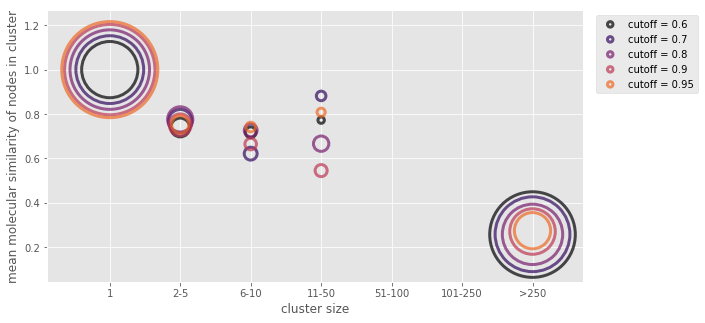

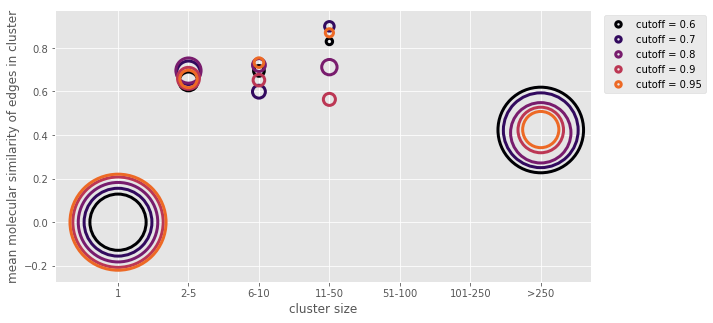

In [272]:
labels_modcos = ['cutoff = ' + str(x) for x in thresholds]

plots_modcos, x_labels, labels = plots_graph_evaluation(MSnets_modcos,
                           M_sim_mol,
                            labels_modcos)

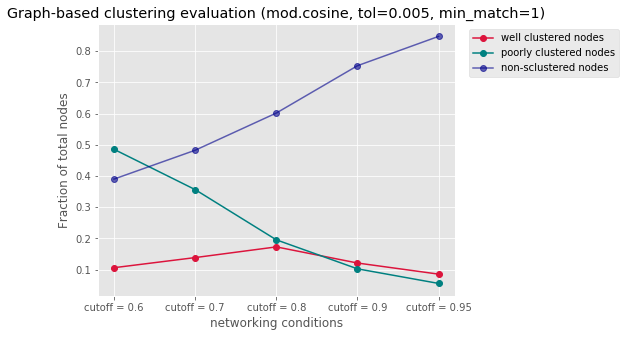

In [294]:
def plot_clustering_performance(data_collection,
                                labels,
                                thres_well = 0.6,
                                thres_poor = 0.4,
                                title = None):
    performance_data = []
    ymax = len(spectra)
    legend_labels = ['well clustered nodes', 'poorly clustered nodes', 'non-sclustered nodes']

    for cluster_data in data_collection:
        nodes_clustered_well = np.sum(cluster_data[(cluster_data['num_nodes']>1) 
                                                   &(cluster_data['ref_sim_mean_nodes']>0.6)]['num_nodes'].values)
        nodes_clustered_poor = np.sum(cluster_data[(cluster_data['num_nodes']>1) 
                                                   &(cluster_data['ref_sim_mean_nodes']<0.4)]['num_nodes'].values)
        nodes_not_clustered = np.sum(cluster_data[(cluster_data['num_nodes']<2)]['num_nodes'].values)

        performance_data.append([nodes_clustered_well, nodes_clustered_poor, nodes_not_clustered])

    fig = plt.figure(figsize=(8,5))
    ax = plt.subplot(111)
    plt.plot(labels, [x[0]/ymax for x in performance_data], 
             'o-', color = 'crimson', label = legend_labels[0])
    plt.plot(labels, [x[1]/ymax for x in performance_data], 
             'o-', color = 'teal', label = legend_labels[1])
    plt.plot(labels, [x[2]/ymax for x in performance_data], 
             'o-', color = 'darkblue', alpha = 0.6, label = legend_labels[2])
    plt.title(title)
    plt.ylabel("Fraction of total nodes")
    plt.xlabel("networking conditions")
    plt.legend()

    # place legend
    chartBox = ax.get_position()
    ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
    lgnd = ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1))


title = 'Graph-based clustering evaluation (mod.cosine, tol=0.005, min_match=1)'
plot_clustering_performance(data_collection_modcos,
                            labels,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title)

### tol = 0.005, min_match = 10

In [290]:
M_modcos = M_modcos_sim_greedy.copy()
M_modcos[np.where(M_modcos_matches_greedy < 10)] = 0

# Create numpy arrays to store top similarities for each spectrum
num_hits = 25
molnet_similars_idx = np.zeros((M_modcos.shape[0],num_hits), dtype=int)
molnet_similars = np.zeros((M_modcos.shape[0],num_hits))

for i in range(M_modcos.shape[0]):
    molnet_similars_idx[i,:] = M_modcos[i,:].argsort()[-num_hits:][::-1]
    molnet_similars[i,:] = M_modcos[i, molnet_similars_idx[i,:]]

In [291]:
MSnets_modcos = []
data_collection_modcos = []
thresholds = [0.6, 0.7, 0.8, 0.9, 0.95]

for thres in thresholds:
    MSnets_modcos.append(net.create_network(molnet_similars_idx,
                                           molnet_similars,
                                           max_links = 10,
                                           cutoff = thres,
                                           link_method = 'single'))
    
for network in MSnets_modcos:
    cluster_data = evaluate_clusters(network,
                                     M_sim_mol)
    
    data_collection_modcos.append(cluster_data)

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


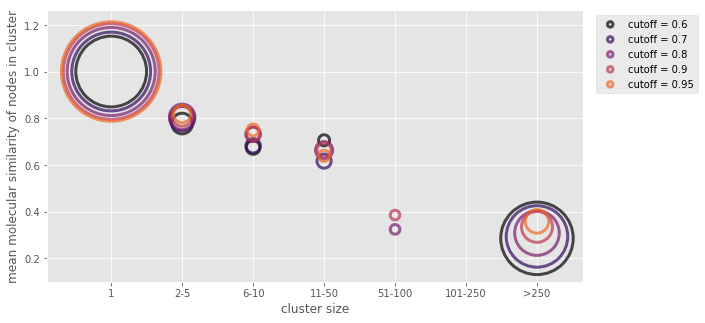

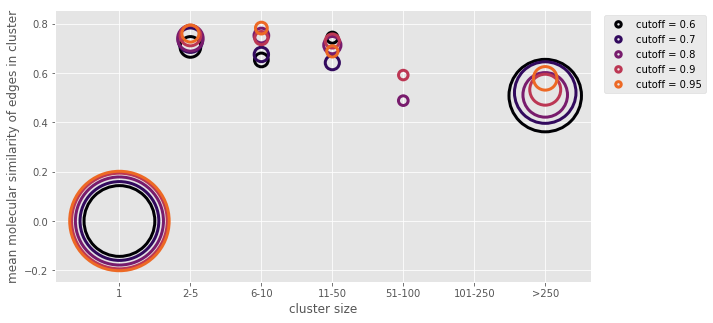

In [292]:
labels_modcos = ['cutoff = ' + str(x) for x in thresholds]

plots_modcos, x_labels, labels = plots_graph_evaluation(MSnets_modcos,
                           M_sim_mol,
                            labels_modcos)

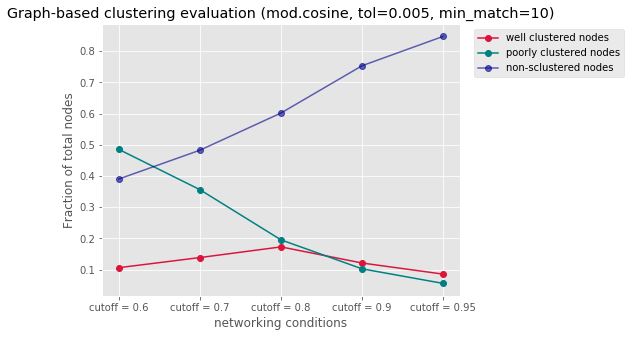

In [293]:
title = 'Graph-based clustering evaluation (mod.cosine, tol=0.005, min_match=10)'
plot_clustering_performance(data_collection_modcos,
                            labels,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title)

# Create network from Spec2Vec similarities

In [295]:
MSnets_s2v = []
data_collection_s2v = []
thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for thres in thresholds:
    MSnets_s2v.append(net.create_network(MS_library.list_similars_ctr_idx,
                                           MS_library.list_similars_ctr,
                                           max_links = 10,
                                           cutoff = thres,
                                           link_method = 'single'))
    
for network in MSnets_s2v:
    cluster_data = evaluate_clusters(network,
                                     M_sim_mol)
    
    data_collection_s2v.append(cluster_data)

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


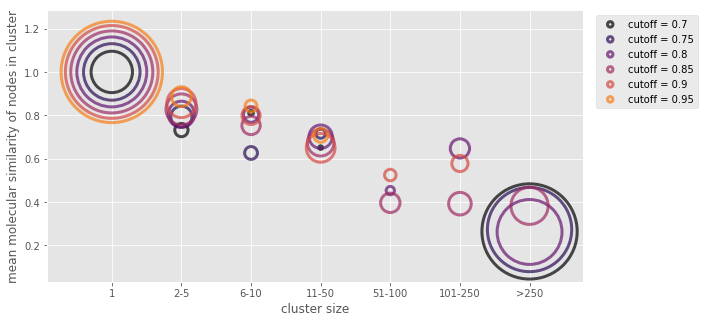

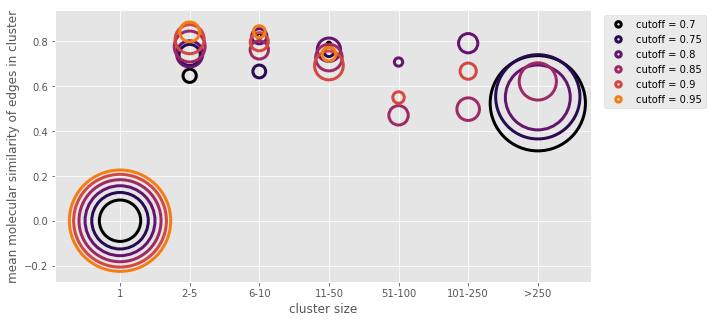

In [296]:
labels = ['cutoff = ' + str(x) for x in thresholds]

plots_modcos, x_labels, labels = plots_graph_evaluation(MSnets_s2v,
                           M_sim_mol,
                            labels)

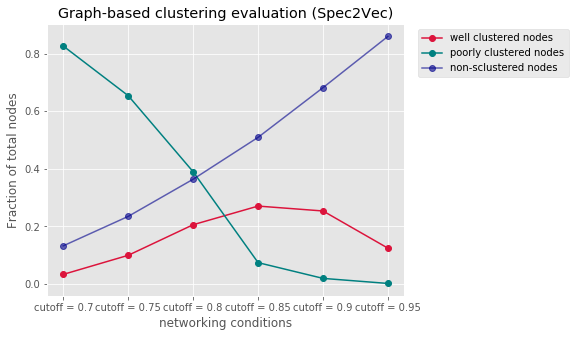

In [297]:
title = 'Graph-based clustering evaluation (Spec2Vec)'
plot_clustering_performance(data_collection_s2v,
                            labels,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title)

# Direct comparison mod.cosine <-> spec2vec

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


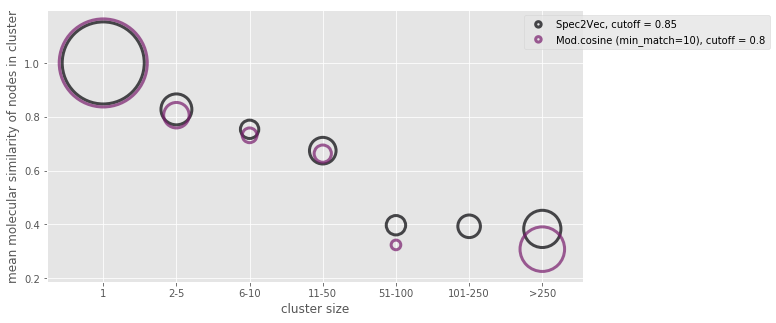

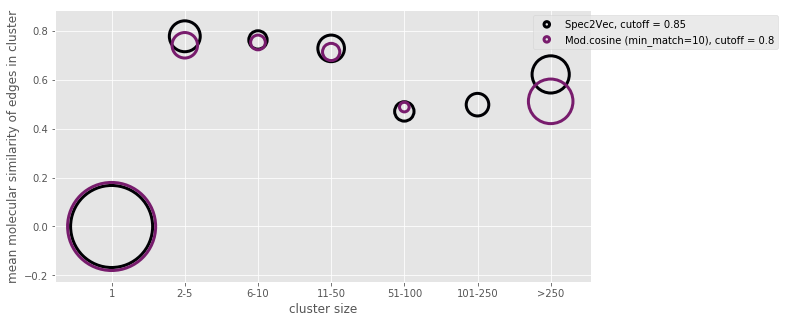

In [300]:
labels_compare = ['Spec2Vec, cutoff = 0.85','Mod.cosine (min_match=10), cutoff = 0.8']

plots_modcos, x_labels, labels = plots_graph_evaluation([MSnets_s2v[3], MSnets_modcos[2]],
                           M_sim_mol,
                            labels_compare)

Text(0.5, 1.0, 'Compare modified cosine and Spec2vec based clusters')

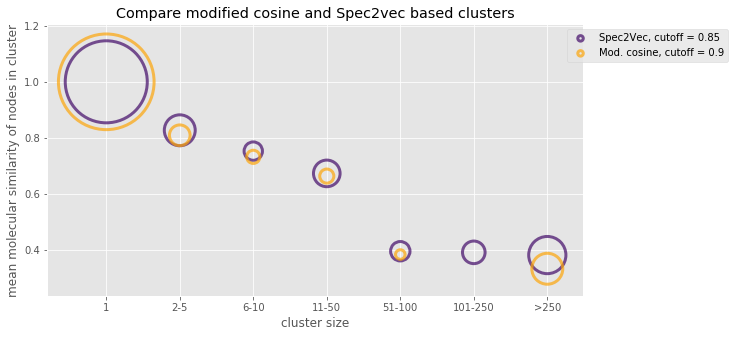

In [159]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)

num_elements, mean_edge_sim, mean_node_sim =  plots[3]
plt.scatter(x_labels, mean_node_sim, s=num_elements, facecolor="None", 
            edgecolors=[cmap(0.2)], lw= 3,
            alpha= 0.7, label='Spec2Vec, cutoff = 0.85')

num_elements, mean_edge_sim, mean_node_sim =  plots_modcos[3]
plt.scatter(x_labels, mean_node_sim, s=num_elements, facecolor="None", 
            edgecolors=[cmap(0.8)], lw= 3,
            alpha= 0.7, label='Mod. cosine, cutoff = 0.9')

plt.xlabel('cluster size')
plt.ylabel('mean molecular similarity of nodes in cluster')   
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
lgnd = ax.legend(loc='upper center', bbox_to_anchor=(1.12, 1))
for i in range(2):
    lgnd.legendHandles[i]._sizes = [30]
    
plt.title("Compare modified cosine and Spec2vec based clusters")

# Additional network trimming, filtering etc.

In [310]:
MSnet = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet_dil, links_added = net.dilate_cluster(MSnet.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 200,   
                           min_cluster_size = 10,
                           max_addition = None,
                           min_weight = 0.85)

MSnet_dil2, links_added = net.dilate_cluster(MSnet_dil.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 100,   
                           min_cluster_size = 10,
                           max_addition = None,
                           min_weight = 0.8)

MSnet_dil3, links_added = net.dilate_cluster(MSnet_dil2.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 100,   
                           min_cluster_size = 5,
                           max_addition = None,
                           min_weight = 0.75)

In [311]:
data_collection_dilation = []
for network in [MSnet, MSnet_dil, MSnet_dil2, MSnet_dil3]:
    cluster_data = evaluate_clusters(network,
                                     M_sim_mol)
    
    data_collection_dilation.append(cluster_data)

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


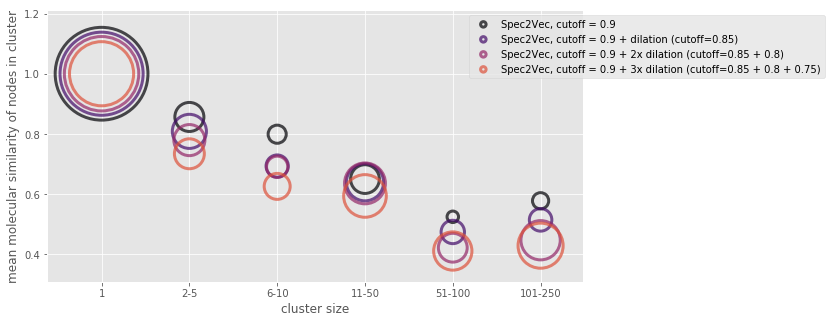

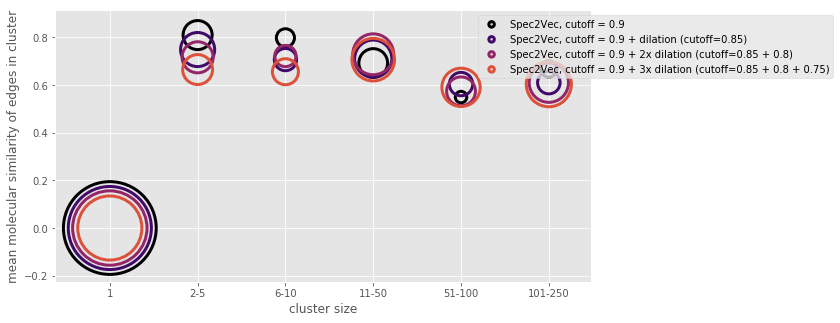

In [312]:
labels_compare = ['Spec2Vec, cutoff = 0.9',
                  'Spec2Vec, cutoff = 0.9 + dilation (cutoff=0.85)',
                 'Spec2Vec, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 0.8 + 0.75)']

plots_modcos, x_labels, labels = plots_graph_evaluation([MSnet, MSnet_dil, MSnet_dil2, MSnet_dil3],
                           M_sim_mol,
                            labels_compare)

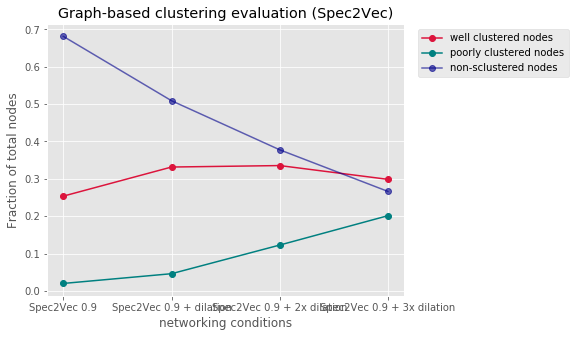

In [313]:
title = 'Graph-based clustering evaluation (Spec2Vec)'
labels_dilation = ['Spec2Vec 0.9',
                  'Spec2Vec 0.9 + dilation',
                  'Spec2Vec 0.9 + 2x dilation',
                  'Spec2Vec 0.9 + 3x dilation']

plot_clustering_performance(data_collection_dilation,
                            labels = labels_dilation,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title)

In [333]:
def dilate_cluster(graph_main,
                   similars_idx,
                   similars,
                   max_cluster_size = 100,   
                   min_cluster_size = 10,
                   max_addition = None,
                   min_weight = 0.5):
    """ Add more links to clusters that are < min_cluster_size.
    This function is in particular made to avoid small remaining clusters or singletons. 
    
    Will only add links if they won't lead to clusters > max_cluster_size,
    and if the links have weights > min_weight.
    Starts iteratively from highest weight links that are not yet part of the network.
    
    Args:
    --------
    graph_main: networkx graph
        Graph, e.g. made using create_network() function. Based on networkx.
    similars_idx: numpy array
        Array with indices of top-n most similar nodes.
    similars: numpy array
        Array with similarity values of top-n most similar nodes.
    max_cluster_size: int
        Maximum desired size of clusters. Default = 100.
    min_cluster_size: int
        Minimum desired size of clusters. Default = 10.
    max_addition: int, None 
        Only add the top max_addition ones per cluster. Ignore if set to None. Default = None.
    min_weight: float
        Set minimum weight to be considered for making link. Default = 0.5.
    """
    
    links_added = []
    
    # Split graph into separate clusters
    graphs = list(nx.connected_component_subgraphs(graph_main))
    
    for graph in graphs:
        cluster_size = len(graph.nodes)
        if cluster_size < min_cluster_size:
            best_scores = []
            potential_links = []
            
            for ID in graph.nodes:
                nodes_connected = []
                for key in graph[ID].keys():
                    nodes_connected.append(key)

                potential_new_links = [(i, x) for i, x in enumerate(similars_idx[ID]) if x not in nodes_connected and x != ID]
                best_score = similars[ID][list(zip(*potential_new_links))[0][0]]
                if best_score >= min_weight:
                    best_scores.append(best_score)
                    potential_link = list(zip(*potential_new_links))[1][0]
                    potential_links.append(potential_link)
                       
            if max_addition is None:
                selected_candidates = np.argsort(best_scores)[::-1]
            else:
                # Only add the top max_addition ones
                selected_candidates = np.argsort(best_scores)[::-1][:max_addition]
            
            for ID in selected_candidates:
                node_ID = list(graph.nodes)[ID]
                
                # Only add link if no cluster > max_cluster_size is formed by it
                if (len(nx.node_connected_component(graph_main, potential_links[ID])) + cluster_size) <= max_cluster_size:
                    # Actual adding of new links
                    #print("new link: (" + str(node_ID) + ", " + str(potential_links[ID]) + ")")
                    graph_main.add_edge(node_ID, potential_links[ID], weight=best_scores[ID])
                    links_added.append((node_ID, potential_links[ID]))
                    # Update cluster_size to keep track of growing clusters
                    cluster_size = len(nx.node_connected_component(graph_main, potential_links[ID]))
    
    return graph_main, links_added

In [338]:
MSnet = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet_dil, links_added = dilate_cluster(MSnet.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 200,   
                           min_cluster_size = 10,
                           max_addition = None,
                           min_weight = 0.85)

MSnet_dil2, links_added = dilate_cluster(MSnet_dil.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_addition = None,
                           min_weight = 0.8)

MSnet_dil3, links_added = dilate_cluster(MSnet_dil2.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_addition = None,
                           min_weight = 0.8)

MSnet_dil4, links_added = dilate_cluster(MSnet_dil3.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_addition = None,
                           min_weight = 0.8)

MSnet_dil5, links_added = dilate_cluster(MSnet_dil4.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 20,   
                           min_cluster_size = 4,
                           max_addition = None,
                           min_weight = 0.7)

In [339]:
data_collection_dilation = []
for network in [MSnet, MSnet_dil, MSnet_dil2, MSnet_dil3, MSnet_dil4, MSnet_dil5]:
    cluster_data = evaluate_clusters(network,
                                     M_sim_mol)
    
    data_collection_dilation.append(cluster_data)

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


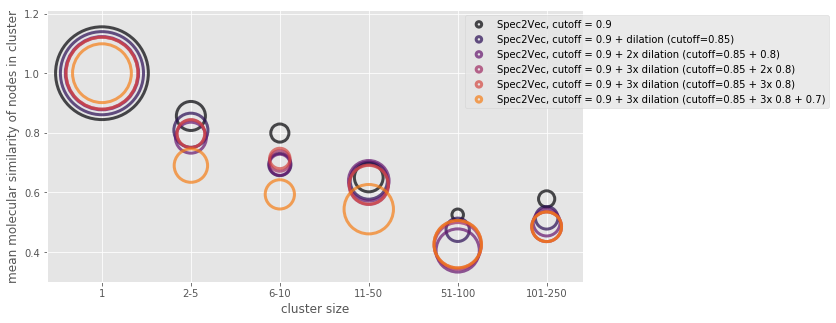

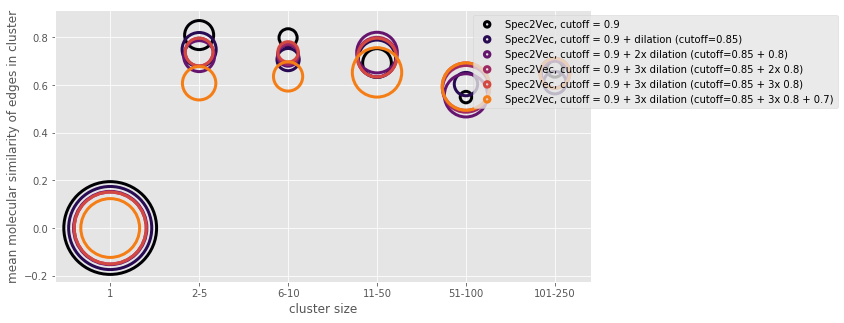

In [342]:
labels_compare = ['Spec2Vec, cutoff = 0.9',
                  'Spec2Vec, cutoff = 0.9 + dilation (cutoff=0.85)',
                 'Spec2Vec, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 2x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8 + 0.7)']

plots_modcos, x_labels, labels = plots_graph_evaluation([MSnet, MSnet_dil, MSnet_dil2, MSnet_dil3, MSnet_dil4, MSnet_dil5],
                           M_sim_mol,
                            labels_compare)

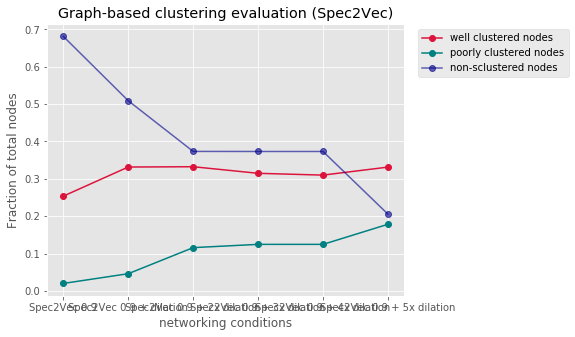

In [341]:
title = 'Graph-based clustering evaluation (Spec2Vec)'
labels_dilation = ['Spec2Vec 0.9',
                  'Spec2Vec 0.9 + dilation',
                  'Spec2Vec 0.9 + 2x dilation',
                  'Spec2Vec 0.9 + 3x dilation',
                  'Spec2Vec 0.9 + 4x dilation',
                  'Spec2Vec 0.9 + 5x dilation']

plot_clustering_performance(data_collection_dilation,
                            labels = labels_dilation,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title)

In [355]:
graphs = list(nx.connected_component_subgraphs(MSnet_dil4))
[(i, len(x.nodes)) for i, x in enumerate(graphs) if len(x.nodes) >10][:20]

[(1, 87),
 (4, 103),
 (5, 110),
 (7, 29),
 (8, 91),
 (21, 22),
 (31, 43),
 (41, 167),
 (70, 90),
 (79, 92),
 (102, 45),
 (159, 61),
 (167, 94),
 (187, 106),
 (239, 89),
 (240, 53),
 (243, 90),
 (253, 17),
 (255, 11),
 (259, 11)]

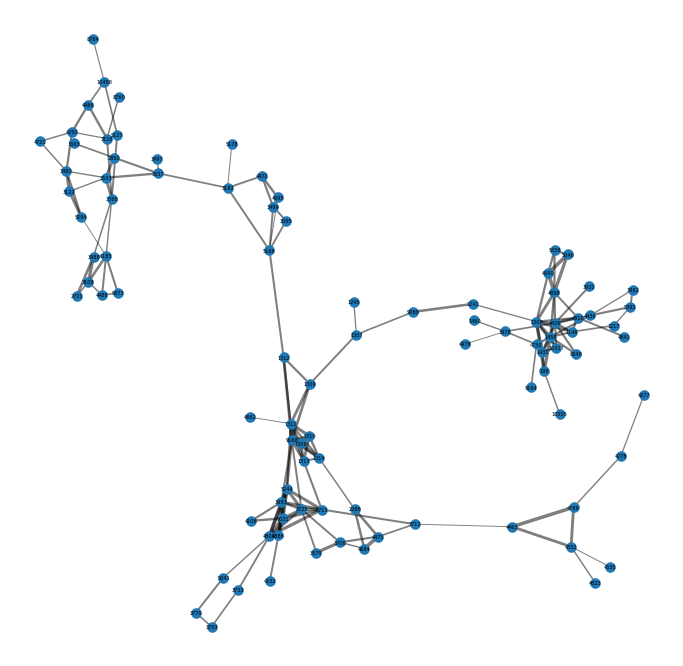

In [359]:
cm = plt.cm.get_cmap('gray')

G = graphs[167]
if len(G.nodes) > 1:
    edges = [(u, v) for (u, v, d) in G.edges(data=True) ]
    weights = [d['weight'] for (u, v, d) in G.edges(data=True) ]
    weights = weights - 0.95*np.min(weights)
    weights = weights/np.max(weights)

    pos = nx.spring_layout(G)  # positions for all nodes
    plt.figure(figsize=(12,12))
    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=100)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=4*weights, alpha=0.5)

    # labels
    nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')

    plt.axis('off')
    plt.show()

Removed 1 edge: [ 551 1328]
Getting from cluster with 201 nodes, to clusters with [81, 120] nodes.
Removed 1 edge: [1649 2219]
Getting from cluster with 120 nodes, to clusters with [57, 63] nodes.
Removed 1 edge: [1985 9116]
Getting from cluster with 63 nodes, to clusters with [42, 21] nodes.
Removed 1 edge: [  23 7601]
Getting from cluster with 200 nodes, to clusters with [182, 18] nodes.
Removed 1 edge: [ 907 9087]
Getting from cluster with 182 nodes, to clusters with [166, 16] nodes.
Removed 1 edge: [3986 8687]
Getting from cluster with 166 nodes, to clusters with [155, 11] nodes.
Removed 2 edges: [5416 6691 6891 7512]
Getting from cluster with 33 nodes, to clusters with [22, 11] nodes.
Removed 1 edge: [7433 7919]
Getting from cluster with 23 nodes, to clusters with [12, 11] nodes.
Removed 2 edges: [ 228  241 2347 2410]
Getting from cluster with 51 nodes, to clusters with [19, 32] nodes.
Removed 1 edge: [1312 5166]
Getting from cluster with 181 nodes, to clusters with [87, 94] nodes

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


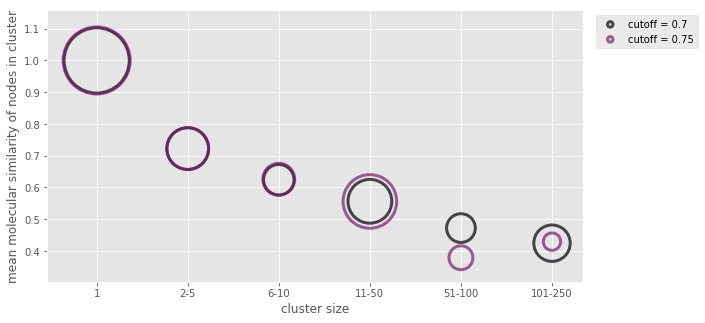

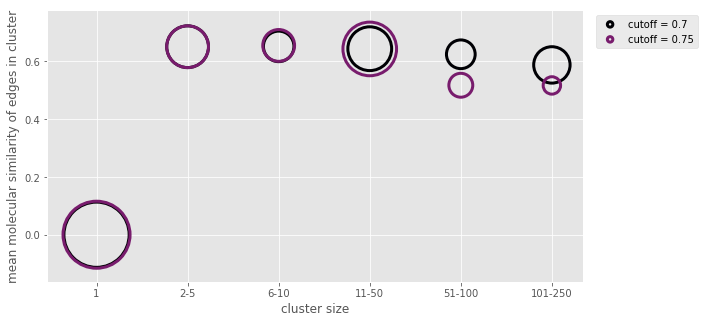

In [200]:
MSnet = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet_dil, links_added = net.dilate_cluster(MSnet.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 200,   
                           min_cluster_size = 10,
                           max_addition = None,
                           min_weight = 0.75)

MSnet5_dil_split, _ = split_cluster(MSnet5_dil.copy(),
                                 max_cluster_size = 20,
                                 min_cluster_size = 10,
                                 max_search_steps = 1000,
                                 max_cuts = 2,
                                 multiple_cuts_per_level = True)

plots5_modified, _,_ = plots_graph_evaluation([MSnet5_dil, MSnet5_dil_split],
                           M_sim_mol,
                      ['cutoff = 0.7', 'cutoff = 0.75', 'cutoff = 0.8', 'cutoff = 0.85', 'cutoff = 0.9'])

Text(0.5, 1.0, 'Compare modified cosine and Spec2vec based clusters')

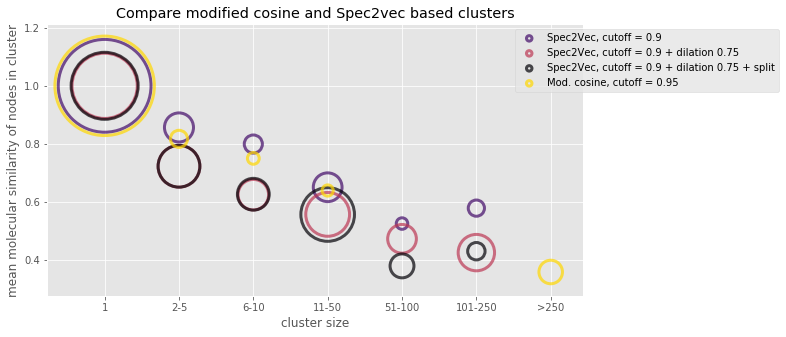

In [206]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)

num_elements, mean_edge_sim, mean_node_sim =  plots[4]
plt.scatter(x_labels, mean_node_sim, s=num_elements, facecolor="None", 
            edgecolors=[cmap(0.2)], lw= 3,
            alpha= 0.7, label='Spec2Vec, cutoff = 0.9')

num_elements, mean_edge_sim, mean_node_sim = plots5_modified[0]
plt.scatter(x_labels, mean_node_sim, s=num_elements, facecolor="None", 
            edgecolors=[cmap(0.5)], lw= 3,
            alpha= 0.7, label='Spec2Vec, cutoff = 0.9 + dilation 0.75')

num_elements, mean_edge_sim, mean_node_sim = plots5_modified[1]
plt.scatter(x_labels, mean_node_sim, s=num_elements, facecolor="None", 
            edgecolors=[cmap(1)], lw= 3,
            alpha= 0.7, label='Spec2Vec, cutoff = 0.9 + dilation 0.75 + split')

num_elements, mean_edge_sim, mean_node_sim =  plots_modcos[4]
plt.scatter(x_labels, mean_node_sim, s=num_elements, facecolor="None", 
            edgecolors='gold', lw= 3,
            alpha= 0.7, label='Mod. cosine, cutoff = 0.95')

plt.xlabel('cluster size')
plt.ylabel('mean molecular similarity of nodes in cluster')   
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
lgnd = ax.legend(loc='upper center', bbox_to_anchor=(1.12, 1))
for i in range(4):
    lgnd.legendHandles[i]._sizes = [30]
    
plt.title("Compare modified cosine and Spec2vec based clusters")

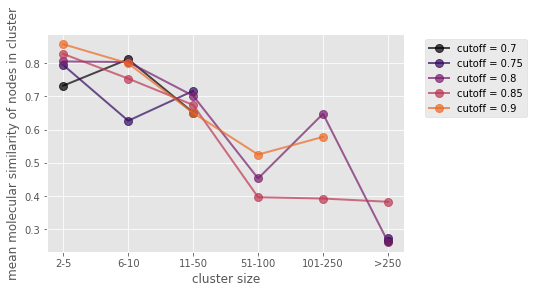

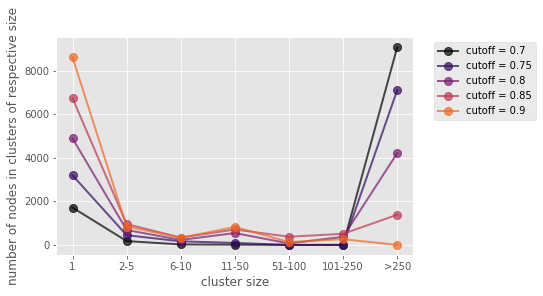

In [37]:
cmap = matplotlib.cm.get_cmap('inferno') #'Spectral')

import matplotlib.colors as colors
import matplotlib.cm as cmx
cm = plt.get_cmap('inferno') #'jet' 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
for i, [num_elements, mean_edge_sim, mean_node_sim] in enumerate(plots):
    colorVal = scalarMap.to_rgba(i/(len(plots)+1))
    plt.plot(x_labels, mean_node_sim, 'o-', alpha= 0.7, lw=2, markersize=8, 
             color= colorVal, label=labels[i])
    plt.xlabel('cluster size')
    plt.ylabel('mean molecular similarity of nodes in cluster')   
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
lgnd = ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1))
for i in range(len(plots)):
    lgnd.legendHandles[i]._sizes = [30]

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
for i, [num_elements, mean_edge_sim, mean_node_sim] in enumerate(plots):
    colorVal = scalarMap.to_rgba(i/(len(plots)+1))
    plt.plot(x_labels, num_elements, 'o-', alpha= 0.7, lw=2, markersize=8, 
             color= colorVal, label=labels[i])
    plt.xlabel('cluster size')
    plt.ylabel('number of nodes in clusters of respective size')
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
lgnd = ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1))
for i in range(len(plots)):
    lgnd.legendHandles[i]._sizes = [30]

In [233]:
cluster_data = evaluate_clusters(MSnet5_dil,
                                     M_sim_mol)

nodes_clustered_well = np.sum(cluster_data[(cluster_data['num_nodes']>1) &(cluster_data['ref_sim_mean_nodes']>0.5)]['num_nodes'].values)
nodes_clustered_poor = np.sum(cluster_data[(cluster_data['num_nodes']>1) &(cluster_data['ref_sim_mean_nodes']<0.3)]['num_nodes'].values)
nodes_not_clustered = np.sum(cluster_data[(cluster_data['num_nodes']<2)]['num_nodes'].values)

print(nodes_clustered_well, nodes_clustered_poor, nodes_not_clustered)
np.sum([nodes_clustered_well, nodes_clustered_poor, nodes_not_clustered])

5461 807 2603


8871

In [235]:
cluster_data = evaluate_clusters(MSnet_modcos5,
                                     M_sim_mol)

nodes_clustered_well = np.sum(cluster_data[(cluster_data['num_nodes']>1) &(cluster_data['ref_sim_mean_nodes']>0.5)]['num_nodes'].values)
nodes_clustered_poor = np.sum(cluster_data[(cluster_data['num_nodes']>1) &(cluster_data['ref_sim_mean_nodes']<0.4)]['num_nodes'].values)
nodes_not_clustered = np.sum(cluster_data[(cluster_data['num_nodes']<2)]['num_nodes'].values)

print(nodes_clustered_well, nodes_clustered_poor, nodes_not_clustered)
np.sum([nodes_clustered_well, nodes_clustered_poor, nodes_not_clustered])

1017 612 9325


10954

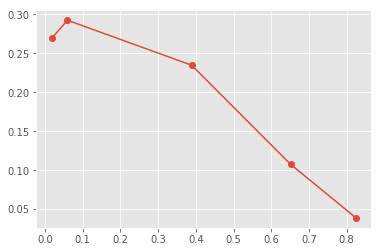

In [238]:
plt.plot([x[1]/ymax for x in performance_data], [x[0]/ymax for x in performance_data], 'o-')

In [49]:
import pandas as pd

def evaluate_clusters(graph_main,
                     M_sim_ref):
    """ Evaluate separate clusters of network based on given reference matrix.
    
    Args:
    -------
    graph_main: networkx graph
        Graph, e.g. made using create_network() function. Based on networkx.
    M_sim_ref: numpy array
        2D array with all reference similarity values between all-vs-all nodes.
    """
        
    # Split graph into separate clusters
    graphs = list(nx.connected_component_subgraphs(graph_main))
    
    num_nodes = []
    num_edges = []
    ref_sim_mean_edges = []
    ref_sim_var_edges = []
    ref_sim_mean_nodes = []
    ref_sim_var_nodes = []
    
    # Loop through clusters
    for graph in graphs:    
        num_nodes.append(len(graph.nodes))
        if len(graph.edges) > 0: # no edges for singletons
            num_edges.append(len(graph.edges)) 
            
            edges = list(graph.edges)
            mol_sim_edges = np.array([M_sim_ref[x] for x in edges])
            mol_sim_edges = np.nan_to_num(mol_sim_edges)
            ref_sim_mean_edges.append(np.mean(mol_sim_edges))
            ref_sim_var_edges.append(np.var(mol_sim_edges)) 
        else:
            num_edges.append(0)
            ref_sim_mean_edges.append(0)
            ref_sim_var_edges.append(0) 
        
        nodes = list(graph.nodes)
        mean_mol_sims = []
        for node in nodes:
            mean_mol_sims.append(M_sim_ref[node, nodes])

        ref_sim_mean_nodes.append(np.mean(mean_mol_sims))
        ref_sim_var_nodes.append(np.var(mean_mol_sims))
    
    cluster_data = pd.DataFrame(list(zip(num_nodes,
                                 num_edges,
                                 ref_sim_mean_edges,
                                 ref_sim_var_edges,
                                 ref_sim_mean_nodes,
                                 ref_sim_var_nodes)), columns=['num_nodes',
                                                             'num_edges',
                                                             'ref_sim_mean_edges',
                                                             'ref_sim_var_edges',
                                                             'ref_sim_mean_nodes',
                                                             'ref_sim_var_nodes'])
    return cluster_data

In [50]:
cluster_data = evaluate_clusters(MSnet1,
                                     M_sim_mol)

In [51]:
cluster_data.head(10)

,num_nodes,num_edges,ref_sim_mean_edges,ref_sim_var_edges,ref_sim_mean_nodes,ref_sim_var_nodes
0,9074,43864,0.523674,0.077106,0.264760,0.018677
1,1,0,0.000000,0.000000,1.000000,0.000000
2,1,0,0.000000,0.000000,1.000000,0.000000
3,3,2,0.448009,0.068529,0.577687,0.128484
4,1,0,0.000000,0.000000,1.000000,0.000000
5,1,0,0.000000,0.000000,1.000000,0.000000
6,1,0,0.000000,0.000000,1.000000,0.000000
7,1,0,0.000000,0.000000,1.000000,0.000000
8,1,0,0.000000,0.000000,1.000000,0.000000
9,1,0,0.000000,0.000000,1.000000,0.000000


Text(0, 0.5, 'cluster size')

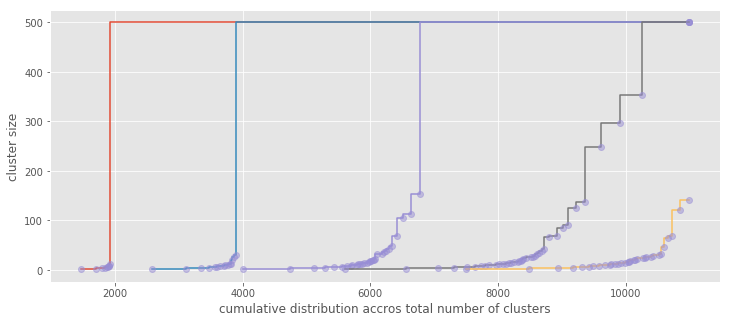

In [105]:
networks = [MSnet1, MSnet2, MSnet3, MSnet4, MSnet5]
y_max = 500
    
""" Run evaluation and series of plots.
"""
size_bins = [1,5,10,50,100,250, len(spectra)]
bins = [0] + [x+1 for x in size_bins]
x_labels = ['1', '2-5', '6-10', '11-50', '51-100', '101-250', '>250']
plt.style.use('ggplot')

data_collection = []
for network in networks:
    cluster_data = evaluate_clusters(network,
                                     M_sim_mol)
    
    data_collection.append(cluster_data)

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
for cluster_data in data_collection:    

    cum_dist = []
    cluster_sizes_unique = cluster_data.sort_values(by=('num_nodes'))['num_nodes'].unique()
    for cluster_size in cluster_sizes_unique:
        num_elements = cluster_size * np.sum(cluster_data['num_nodes'] == cluster_size)
        cum_dist.append((cluster_size, num_elements))
    y,x = np.array(list((zip(*cum_dist))))
    y[y>y_max] = y_max
    x_cum = [np.sum(x[:(i+1)]) for i in range(len(x))]
    plt.step(x_cum, y, where='pre', label='post')
    plt.plot(x_cum, y, 'C2o', alpha=0.5)    

plt.xlabel('cumulative distribution accros total number of clusters')
plt.ylabel('cluster size')

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'mean molecular similarity of edges in cluster')

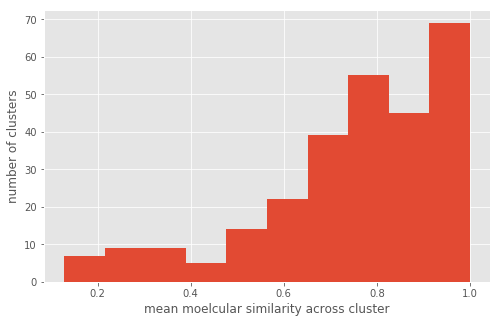

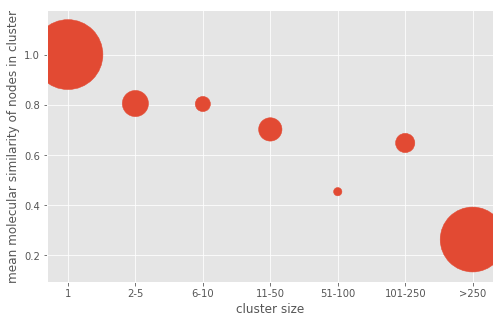

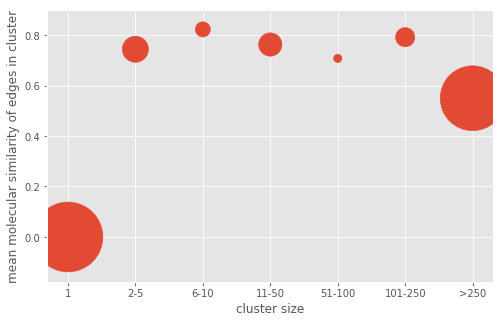

In [97]:
MSnet = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.8,
                           link_method = 'single')

cluster_data = net.evaluate_clusters(MSnet,
                                     M_sim_mol)

plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.hist(cluster_data[cluster_data['num_nodes'] > 2]['ref_sim_mean_edges'].values)
plt.xlabel('mean moelcular similarity across cluster')
plt.ylabel('number of clusters')

cluster_sizes = cluster_data['num_nodes'].values
size_bins = [1,5,10,50,100,250, len(spectra)]
bins = [0] + [x+1 for x in size_bins]
labels = ['1', '2-5', '6-10', '11-50', '51-100', '101-250', '>250']

num_elements = []
mean_edge_sim = []
mean_node_sim = []
for i in range(len(bins)-1):
    num_elements.append(np.sum(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['num_nodes'].values))
    mean_edge_sim.append(np.mean(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['ref_sim_mean_edges'].values))

    mean_node_sim.append(np.mean(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['ref_sim_mean_nodes'].values))
        
num_elements[0] = len(spectra) - np.sum(num_elements[1:])
if np.isnan(mean_edge_sim[0]):
     mean_edge_sim[0] = 0

plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.scatter(labels, mean_node_sim, s=num_elements)
plt.xlabel('cluster size')
plt.ylabel('mean molecular similarity of nodes in cluster')   

plt.figure(figsize=(8,5))
plt.scatter(labels, mean_edge_sim, s=num_elements)#, cmap='winter_r', c=num_elements)
plt.xlabel('cluster size')
plt.ylabel('mean molecular similarity of edges in cluster') 

In [179]:
MSnet0 = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet1, links = net.split_cluster(MSnet0.copy(),
                                 max_cluster_size = 100,
                                 min_cluster_size = 10,
                                 max_search_steps = 1000,
                                 max_cuts = 2,
                                 multiple_cuts_per_level = True)

MSnet2 = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.8,
                           link_method = 'single')

MSnet3, links = net.split_cluster(MSnet2.copy(),
                                 max_cluster_size = 100,
                                 min_cluster_size = 10,
                                 max_search_steps = 1000,
                                 max_cuts = 2,
                                 multiple_cuts_per_level = True)


Removed 1 edge: [6021 6782]
Getting from cluster with 141 nodes, to clusters with [126, 15] nodes.
Removed 2 edges: [8816 8821 8821 8822]
Getting from cluster with 122 nodes, to clusters with [83, 39] nodes.
Removed 1 edge: [ 4749 10505]
Getting from cluster with 4212 nodes, to clusters with [3695, 517] nodes.
Removed 1 edge: [9029 9485]
Getting from cluster with 3695 nodes, to clusters with [3642, 53] nodes.
Removed 1 edge: [ 275 3848]
Getting from cluster with 3642 nodes, to clusters with [3619, 23] nodes.
Removed 1 edge: [3202 3293]
Getting from cluster with 3619 nodes, to clusters with [3602, 17] nodes.
Removed 1 edge: [7454 7591]
Getting from cluster with 3602 nodes, to clusters with [3585, 17] nodes.
Removed 1 edge: [5930 5949]
Getting from cluster with 3585 nodes, to clusters with [3572, 13] nodes.
Removed 1 edge: [1306 8716]
Getting from cluster with 3572 nodes, to clusters with [3560, 12] nodes.
Removed 1 edge: [9397 9398]
Getting from cluster with 3560 nodes, to clusters with

In [182]:
MSnet4, links = net.split_cluster(MSnet3.copy(),
                                 max_cluster_size = 250,
                                 min_cluster_size = 10,
                                 max_search_steps = 1000,
                                 max_cuts = 3,
                                 multiple_cuts_per_level = True)

Removed 3 edges: [ 3143  3477  3253  8079 10198 10628]
Getting from cluster with 2922 nodes, to clusters with [2212, 710] nodes.
Removed 3 edges: [6389 6951 6444 6951 6484 6951]
Getting from cluster with 2212 nodes, to clusters with [2195, 17] nodes.
Removed 3 edges: [2663 3637 3129 3637 3308 3639]
Getting from cluster with 2195 nodes, to clusters with [2184, 11] nodes.
Removed 2 edges: [342 378 378 564]
Getting from cluster with 522 nodes, to clusters with [512, 10] nodes.
Removed 1 edge: [5679 6401]
Getting from cluster with 517 nodes, to clusters with [489, 28] nodes.
Removed 1 edge: [1247 1627]
Getting from cluster with 489 nodes, to clusters with [477, 12] nodes.
Removed 2 edges: [ 4738  5797  5797 10384]
Getting from cluster with 477 nodes, to clusters with [467, 10] nodes.
Removed 2 edges: [6179 6553 6321 6553]
Getting from cluster with 467 nodes, to clusters with [457, 10] nodes.


C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


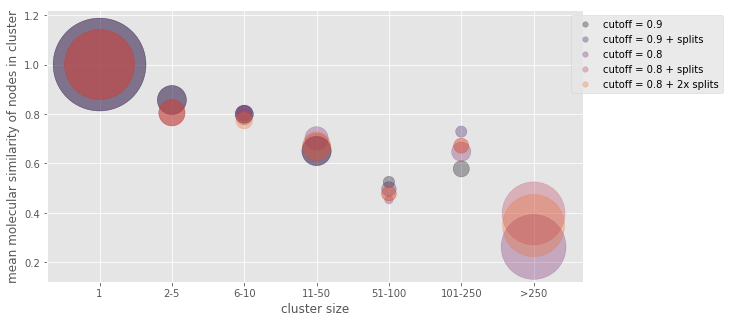

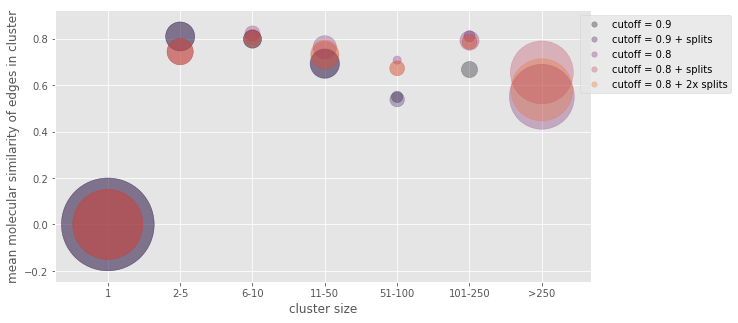

In [183]:
plots, x_labels, labels = plots_graph_evaluation([MSnet0, MSnet1, MSnet2, MSnet3, MSnet4],
                           M_sim_mol,
                      ['cutoff = 0.9', 'cutoff = 0.9 + splits', 'cutoff = 0.8', 
                       'cutoff = 0.8 + splits', 'cutoff = 0.8 + 2x splits'])

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning:

Text(0, 0.5, 'mean molecular similarity of edges in cluster')

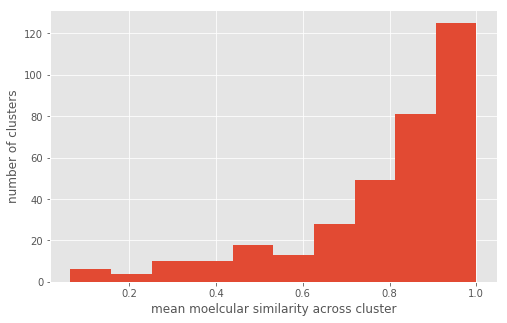

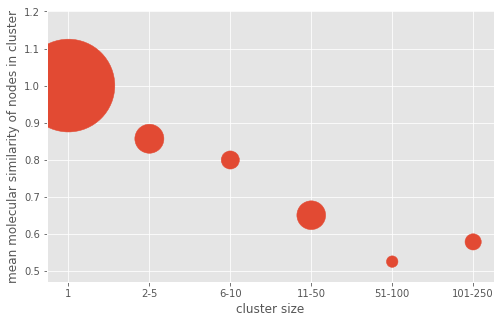

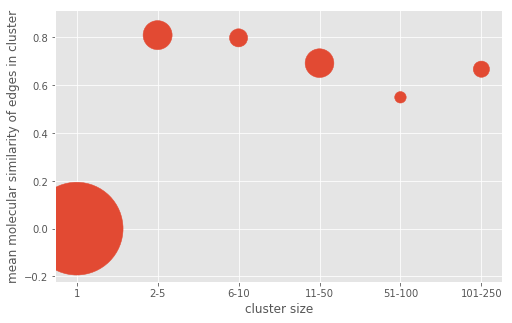

In [99]:
MSnet = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

cluster_data = net.evaluate_clusters(MSnet,
                                     M_sim_mol)

plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.hist(cluster_data[cluster_data['num_nodes'] > 2]['ref_sim_mean_edges'].values)
plt.xlabel('mean moelcular similarity across cluster')
plt.ylabel('number of clusters')

cluster_sizes = cluster_data['num_nodes'].values
size_bins = [1,5,10,50,100,250, len(spectra)]
bins = [0] + [x+1 for x in size_bins]
labels = ['1', '2-5', '6-10', '11-50', '51-100', '101-250', '>250']

num_elements = []
mean_edge_sim = []
mean_node_sim = []
for i in range(len(bins)-1):
    num_elements.append(np.sum(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['num_nodes'].values))
    mean_edge_sim.append(np.mean(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['ref_sim_mean_edges'].values))

    mean_node_sim.append(np.mean(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['ref_sim_mean_nodes'].values))
        
num_elements[0] = len(spectra) - np.sum(num_elements[1:])
if np.isnan(mean_edge_sim[0]):
     mean_edge_sim[0] = 0

plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.scatter(labels, mean_node_sim, s=num_elements)
plt.xlabel('cluster size')
plt.ylabel('mean molecular similarity of nodes in cluster')   

plt.figure(figsize=(8,5))
plt.scatter(labels, mean_edge_sim, s=num_elements)#, cmap='winter_r', c=num_elements)
plt.xlabel('cluster size')
plt.ylabel('mean molecular similarity of edges in cluster') 

Removed 1 edge: [6021 6782]
Getting from cluster with 141 nodes, to clusters with [126, 15] nodes.
Removed 2 edges: [8816 8821 8821 8822]
Getting from cluster with 122 nodes, to clusters with [83, 39] nodes.


C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning:

Text(0, 0.5, 'mean molecular similarity of edges in cluster')

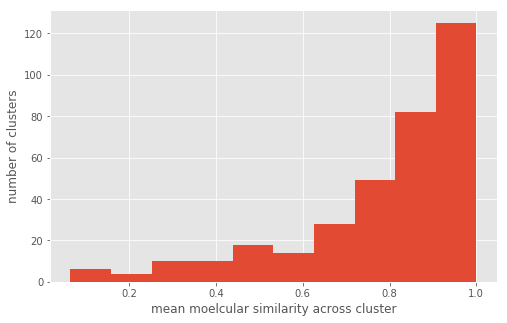

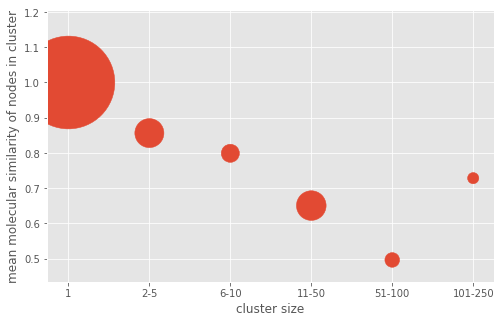

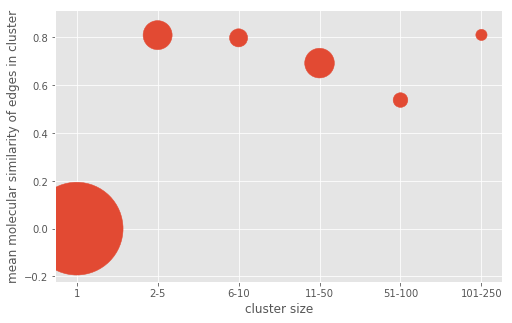

In [119]:
MSnet0 = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet, links = net.split_cluster(MSnet0.copy(),
                                 max_cluster_size = 100,
                                 min_cluster_size = 10,
                                 max_search_steps = 1000,
                                 max_cuts = 2,
                                 multiple_cuts_per_level = True)

cluster_data = net.evaluate_clusters(MSnet,
                                     M_sim_mol)

plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.hist(cluster_data[cluster_data['num_nodes'] > 2]['ref_sim_mean_edges'].values)
plt.xlabel('mean moelcular similarity across cluster')
plt.ylabel('number of clusters')

cluster_sizes = cluster_data['num_nodes'].values
size_bins = [1,5,10,50,100,250, len(spectra)]
bins = [0] + [x+1 for x in size_bins]
labels = ['1', '2-5', '6-10', '11-50', '51-100', '101-250', '>250']

num_elements = []
mean_edge_sim = []
mean_node_sim = []
for i in range(len(bins)-1):
    num_elements.append(np.sum(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['num_nodes'].values))
    mean_edge_sim.append(np.mean(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['ref_sim_mean_edges'].values))

    mean_node_sim.append(np.mean(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['ref_sim_mean_nodes'].values))
        
num_elements[0] = len(spectra) - np.sum(num_elements[1:])
if np.isnan(mean_edge_sim[0]):
     mean_edge_sim[0] = 0

plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.scatter(labels, mean_node_sim, s=num_elements)
plt.xlabel('cluster size')
plt.ylabel('mean molecular similarity of nodes in cluster')   

plt.figure(figsize=(8,5))
plt.scatter(labels, mean_edge_sim, s=num_elements)#, cmap='winter_r', c=num_elements)
plt.xlabel('cluster size')
plt.ylabel('mean molecular similarity of edges in cluster') 

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning:

Text(0, 0.5, 'mean molecular similarity of edges in cluster')

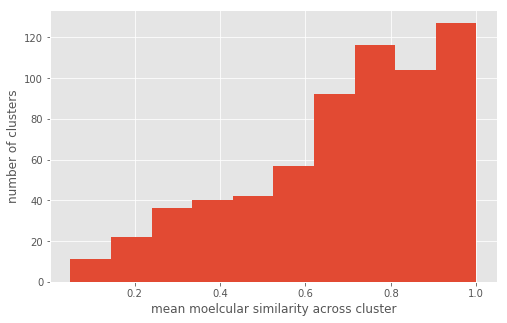

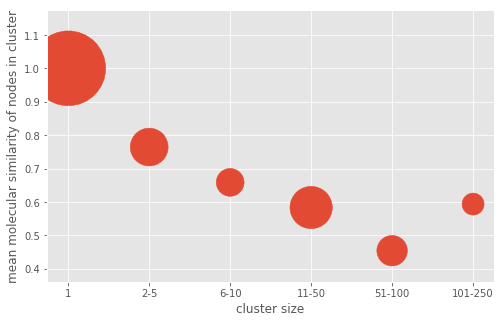

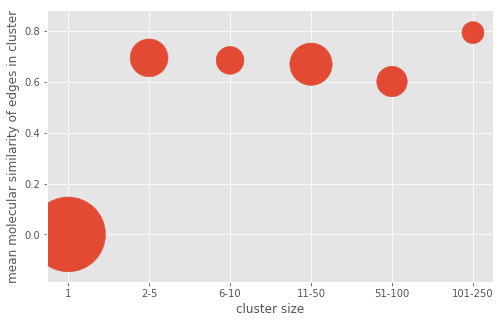

In [120]:
MSnet, links_added = net.dilate_cluster(MSnet,
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 100,   
                           min_cluster_size = 10,
                           max_addition = None,
                           min_weight = 0.8)

cluster_data = net.evaluate_clusters(MSnet,
                                     M_sim_mol)

plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.hist(cluster_data[cluster_data['num_nodes'] > 2]['ref_sim_mean_edges'].values)
plt.xlabel('mean moelcular similarity across cluster')
plt.ylabel('number of clusters')

cluster_sizes = cluster_data['num_nodes'].values
size_bins = [1,5,10,50,100,250, len(spectra)]
bins = [0] + [x+1 for x in size_bins]
labels = ['1', '2-5', '6-10', '11-50', '51-100', '101-250', '>250']

num_elements = []
mean_edge_sim = []
mean_node_sim = []
for i in range(len(bins)-1):
    num_elements.append(np.sum(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['num_nodes'].values))
    mean_edge_sim.append(np.mean(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['ref_sim_mean_edges'].values))

    mean_node_sim.append(np.mean(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['ref_sim_mean_nodes'].values))
        
num_elements[0] = len(spectra) - np.sum(num_elements[1:])
if np.isnan(mean_edge_sim[0]):
     mean_edge_sim[0] = 0

plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.scatter(labels, mean_node_sim, s=num_elements)
plt.xlabel('cluster size')
plt.ylabel('mean molecular similarity of nodes in cluster')   

plt.figure(figsize=(8,5))
plt.scatter(labels, mean_edge_sim, s=num_elements)#, cmap='winter_r', c=num_elements)
plt.xlabel('cluster size')
plt.ylabel('mean molecular similarity of edges in cluster') 

In [107]:
MSnet0 = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet, links_added = net.dilate_cluster(MSnet0,
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 100,   
                           min_cluster_size = 10,
                           max_addition = None,
                           min_weight = 0.7)

In [108]:
cluster_data = net.evaluate_clusters(MSnet,
                                     M_sim_mol)

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'mean molecular similarity of edges in cluster')

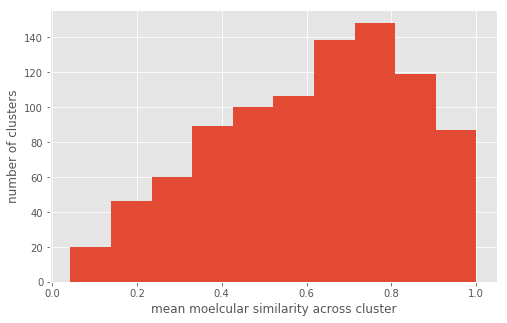

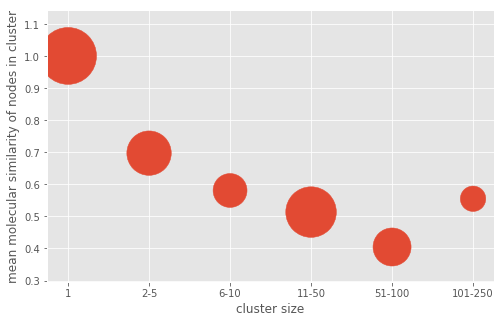

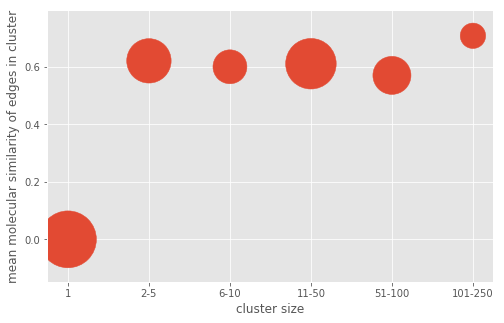

In [109]:
plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.hist(cluster_data[cluster_data['num_nodes'] > 2]['ref_sim_mean_edges'].values)
plt.xlabel('mean moelcular similarity across cluster')
plt.ylabel('number of clusters')

cluster_sizes = cluster_data['num_nodes'].values
size_bins = [1,5,10,50,100,250, len(spectra)]
bins = [0] + [x+1 for x in size_bins]
labels = ['1', '2-5', '6-10', '11-50', '51-100', '101-250', '>250']

num_elements = []
mean_edge_sim = []
mean_node_sim = []
for i in range(len(bins)-1):
    num_elements.append(np.sum(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['num_nodes'].values))
    mean_edge_sim.append(np.mean(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['ref_sim_mean_edges'].values))

    mean_node_sim.append(np.mean(cluster_data[(cluster_data['num_nodes'] < bins[i+1]) 
                & (cluster_data['num_nodes'] > bins[i]) ]['ref_sim_mean_nodes'].values))
        
num_elements[0] = len(spectra) - np.sum(num_elements[1:])
if np.isnan(mean_edge_sim[0]):
     mean_edge_sim[0] = 0

plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.scatter(labels, mean_node_sim, s=num_elements)
plt.xlabel('cluster size')
plt.ylabel('mean molecular similarity of nodes in cluster')   

plt.figure(figsize=(8,5))
plt.scatter(labels, mean_edge_sim, s=num_elements)#, cmap='winter_r', c=num_elements)
plt.xlabel('cluster size')
plt.ylabel('mean molecular similarity of edges in cluster') 

In [261]:
def erode_clusters(graph_main,
                   max_cluster_size = 100,   
                   keep_weights_above = 0.8):
    """ Remove links from clusters that are > max_cluster_size.
    This function is in particular made to avoid small remaining clusters or singletons. 
    
    Will only add links if they won't lead to clusters > max_cluster_size,
    and if the links have weights > min_weight.
    Starts iteratively from highest weight links that are not yet part of the network.
    
    Args:
    --------
    graph_main: networkx graph
        Graph, e.g. made using create_network() function. Based on networkx.
    max_cluster_size: int
        Maximum desired size of clusters. Default = 100.
    keep_weights_above: float
        Set threshold above which weights will not be removed. Default = 0.8.
    """
    
    links_removed = []
    
    # Split graph into separate clusters
    graphs = list(nx.connected_component_subgraphs(graph_main))
    
    for graph in graphs:
        cluster_size = len(graph.nodes)
        while cluster_size > max_cluster_size:
            
            edges = list(graph.edges)
            edges_weights = np.array([graph[x[0]][x[1]]['weight'] for x in edges])

            weakest_edge = edges_weights.argsort()[0]
            if edges_weights[weakest_edge] < keep_weights_above:
                print("Remove edge:", edges[weakest_edge][0], edges[weakest_edge][1])
                graph.remove_edge(edges[weakest_edge][0], edges[weakest_edge][1])
                graph_main.remove_edge(edges[weakest_edge][0], edges[weakest_edge][1])
                links_removed.append(edges[weakest_edge])

            # If link removal caused split of cluster:
            if not nx.is_connected(graph):
                subgraphs = list(nx.connected_component_subgraphs(graph))
                print("Getting from cluster with", len(graph.nodes), "nodes, to clusters with",
                     [len(x.nodes) for x in subgraphs], "nodes.")
                idx1 = np.argmax([len(x.nodes) for x in subgraphs])
                graph = subgraphs[idx1] # keep largest subcluster here
            
            cluster_size = len(graph.nodes)
    
    return graph_main, links_removed

In [268]:
graphs = list(nx.connected_component_subgraphs(graph_main))
graph2, links_removed = erode_clusters(graphs[46],
                                   max_cluster_size = 10,   
                                   keep_weights_above = 0.8)

KeyError: 'weight'

In [204]:
cluster_data[cluster_data['num_nodes'] > 10]

,num_nodes,num_edges,ref_sim_mean_edges,ref_sim_var_edges,ref_sim_mean_nodes,ref_sim_var_nodes
1,2908,54937,0.392557,0.056684,0.233042,0.020067
3,512,10562,0.569794,0.053223,0.437960,0.028267
12,69,539,0.218635,0.023517,0.204306,0.021607
13,117,1129,0.233043,0.029441,0.202117,0.018075
19,42,184,0.167860,0.013873,0.177292,0.025143
20,15,25,0.203042,0.034745,0.228900,0.054905
24,111,996,0.660692,0.035443,0.421219,0.054982
26,31,195,0.392253,0.021240,0.315376,0.043514
27,98,634,0.549068,0.073957,0.368089,0.048545
28,102,641,0.349300,0.037031,0.265266,0.021711


Text(0, 0.5, 'number of clusters')

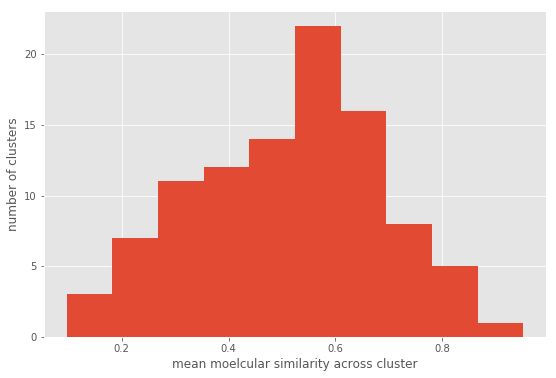

In [212]:
plt.style.use('ggplot')
plt.figure(figsize=(9,6))
plt.hist(cluster_data[cluster_data['num_nodes'] > 10]['ref_sim_mean_edges'].values)
plt.xlabel('mean moelcular similarity across cluster')
plt.ylabel('number of clusters')

Text(0, 0.5, 'number of clusters')

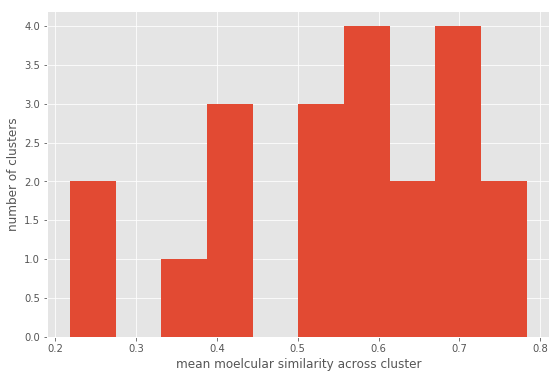

In [213]:
plt.style.use('ggplot')
plt.figure(figsize=(9,6))
plt.hist(cluster_data[cluster_data['num_nodes'] > 50]['ref_sim_mean_edges'].values)
plt.xlabel('mean moelcular similarity across cluster')
plt.ylabel('number of clusters')

Text(0, 0.5, 'number of clusters')

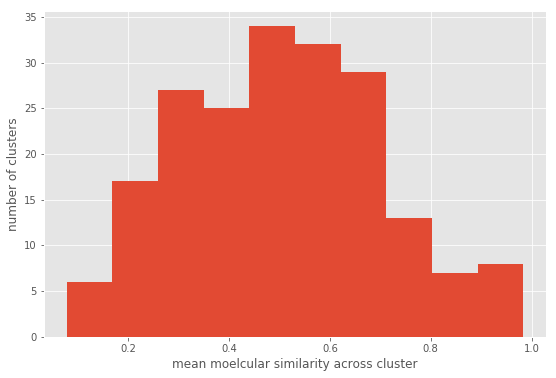

In [221]:
plt.style.use('ggplot')
plt.figure(figsize=(9,6))
plt.hist(cluster_data[(cluster_data['num_nodes'] < 51) & (cluster_data['num_nodes'] > 5)]['ref_sim_mean_edges'].values)
plt.xlabel('mean moelcular similarity across cluster')
plt.ylabel('number of clusters')

Text(0, 0.5, 'log number of clusters')

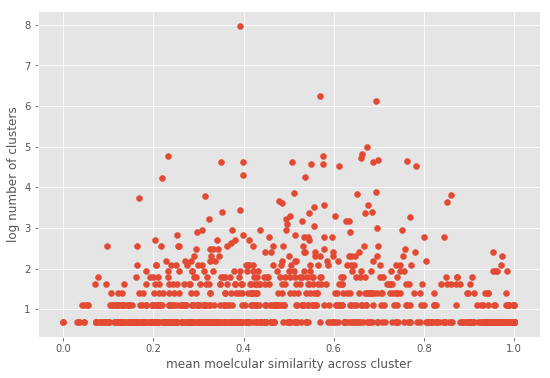

In [224]:
plt.style.use('ggplot')
plt.figure(figsize=(9,6))
plt.scatter(cluster_data['ref_sim_mean_edges'].values, np.log(cluster_data['num_nodes'].values))
plt.xlabel('mean moelcular similarity across cluster')
plt.ylabel('log number of clusters')

In [65]:
list_similars_idx = MS_library.list_similars_ctr_idx
list_similars = MS_library.list_similars_ctr
MSnet = create_network(list_similars_idx,
                   list_similars,
                   max_links = 10,
                   cutoff = 0.8,
                   link_method = 'single') #'mutual')

In [66]:
graphs = list(nx.connected_component_subgraphs(MSnet))
print([(i, len(x.nodes)) for i, x in enumerate(graphs) if len(x.nodes) > 5])

[(1, 4212), (16, 22), (26, 43), (117, 6), (152, 7), (193, 6), (226, 7), (237, 6), (300, 6), (390, 14), (524, 12), (632, 8), (750, 69), (766, 154), (817, 12), (828, 8), (838, 6), (841, 15), (893, 6), (933, 8), (1015, 6), (1151, 9), (1178, 6), (1198, 9), (1207, 14), (1213, 6), (1227, 6), (1403, 7), (1426, 15), (1433, 6), (1474, 16), (1476, 8), (1477, 21), (1478, 105), (1479, 10), (1482, 32), (1483, 112), (1494, 10), (1495, 13), (1496, 38), (1497, 10), (1501, 15), (1504, 33), (1509, 20), (1515, 19), (1516, 8), (1519, 16), (1521, 6), (1523, 6), (1527, 33), (1533, 10), (1536, 8), (1538, 7), (1542, 8), (1578, 10), (1580, 7), (1595, 8), (1634, 6), (1733, 6), (1743, 6), (1794, 7), (1806, 49), (1813, 7), (1821, 10), (1826, 8), (1861, 13), (1875, 6), (1877, 6), (1906, 7), (1937, 11), (1945, 7), (2010, 10), (2064, 6), (2076, 13), (2093, 18), (2180, 7), (2306, 12), (2765, 6), (4107, 37), (4392, 6)]


In [67]:
graph_main, links = dilate_cluster(MSnet,
                               list_similars_idx,
                               list_similars,
                               max_cluster_size = 100,   
                               min_cluster_size = 10,
                               max_addition = None,
                               min_weight = 0.6)

In [68]:
graphs = list(nx.connected_component_subgraphs(graph_main))
print([(i, len(x.nodes)) for i, x in enumerate(graphs) if len(x.nodes) > 5])

[(1, 4212), (8, 10), (11, 69), (12, 117), (13, 9), (15, 6), (17, 6), (18, 42), (19, 15), (23, 111), (26, 10), (27, 41), (28, 13), (29, 8), (34, 8), (37, 10), (38, 8), (41, 9), (45, 15), (50, 12), (54, 106), (57, 7), (59, 18), (61, 8), (62, 22), (64, 10), (66, 16), (67, 17), (69, 25), (70, 10), (73, 9), (75, 6), (79, 69), (80, 8), (82, 13), (83, 7), (84, 15), (85, 46), (88, 15), (89, 12), (90, 10), (94, 10), (97, 13), (103, 13), (112, 71), (119, 12), (120, 8), (126, 6), (127, 8), (131, 7), (132, 6), (133, 16), (134, 49), (135, 6), (139, 37), (143, 12), (144, 8), (145, 13), (151, 6), (156, 9), (157, 35), (166, 43), (170, 16), (173, 21), (184, 11), (185, 29), (197, 15), (198, 10), (202, 11), (204, 8), (205, 10), (207, 10), (212, 19), (213, 34), (215, 45), (218, 32), (220, 17), (237, 8), (238, 24), (239, 13), (247, 12), (261, 9), (267, 13), (269, 6), (275, 8), (278, 6), (301, 7), (305, 12), (306, 7), (308, 6), (312, 30), (314, 6), (325, 38), (328, 6), (329, 6), (345, 96), (346, 19), (347, 

In [81]:
len(graph_main), len(sub_spectra_metadata)

(10998, 10998)

In [82]:
sub_spectra_metadata.head()

,doc_ID,gnps_ID,name,title,precursor_mz,num_peaks_losses,inchi,inchikey,smiles,charge
0,0,CCMSLIB00005435506,cholic acid M+Na,NaN,431.277,35,"""InChI=1S/C24H40O5/c1-13(4-7-21(28)29)16-5-6-1...",BHQCQFFYRZLCQQ-IHELEQLESA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1
1,1,CCMSLIB00005435507,deoxycholic acid M-H2O+H,NaN,375.289,157,"""InChI=1S/C24H40O4/c1-14(4-9-22(27)28)18-7-8-1...",KXGVEGMKQFWNSR-BKAWJTANSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1
2,2,CCMSLIB00005435517,glycocholic acid 2M+H,NaN,931.625,91,"""InChI=1S/C26H43NO6/c1-14(4-7-22(31)27-13-23(3...",RFDAIACWWDREDC-VKRKCYKBSA-N,C[C@H](CCC(=O)NCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([...,1
3,3,CCMSLIB00005435523,glycodeoxycholic acid 2M+Na,NaN,921.617,24,"""InChI=1S/C26H43NO5/c1-15(4-9-23(30)27-14-24(3...",WVULKSPCQVQLCU-JKPPYMBGSA-N,C[C@H](CCC(=O)NCC(=O)O)[C@H]1CCC2[C@@]1([C@H](...,1
4,4,CCMSLIB00005435528,glycohyocholic acid 2M+K,NaN,953.606,15,"""InChI=1S/C26H43NO6/c1-14(4-7-20(29)27-13-21(3...",ZQYUKJFJPJDMMR-ZDWCHQGWSA-N,C[C@H](CCC(=O)NCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(C...,1


In [69]:
list_similars_idx = MS_library.list_similars_ctr_idx
list_similars = MS_library.list_similars_ctr
MSnet = create_network(list_similars_idx,
                   list_similars,
                   max_links = 10,
                   cutoff = 0.8,
                   link_method = 'single') #'mutual')

In [70]:
graph_main, links_added, links_removed = refine_network(MSnet,
                                                       weigh_bounds = (0.6, 1),
                                                       max_cluster_size = 100,
                                                       min_cluster_size = 10,
                                                       max_search_steps = 1000,
                                                       max_cuts = 2,
                                                       max_split_iterations = 2,
                                                       basic_splitting = False,
                                                       dilation = True)

------------------------------------------------------------
Splitting iteration: 1 Max cluster size = 4212 

Removed 1 edge: [ 4749 10505]
Getting from cluster with 4212 nodes, to clusters with [3695, 517] nodes.
Removed 1 edge: [9029 9485]
Getting from cluster with 3695 nodes, to clusters with [3642, 53] nodes.
Removed 1 edge: [ 275 3848]
Getting from cluster with 3642 nodes, to clusters with [3619, 23] nodes.
Removed 1 edge: [3202 3293]
Getting from cluster with 3619 nodes, to clusters with [3602, 17] nodes.
Removed 1 edge: [7454 7591]
Getting from cluster with 3602 nodes, to clusters with [3585, 17] nodes.
Removed 1 edge: [5930 5949]
Getting from cluster with 3585 nodes, to clusters with [3572, 13] nodes.
Removed 1 edge: [1306 8716]
Getting from cluster with 3572 nodes, to clusters with [3560, 12] nodes.
Removed 1 edge: [9397 9398]
Getting from cluster with 3560 nodes, to clusters with [3548, 12] nodes.
Removed 1 edge: [4415 4621]
Getting from cluster with 3548 nodes, to clusters w

(array([1062.,  511.,  126.,  107.,   63.,   28.,    7.,   11.]),
 array([  0,   2,   4,   6,  10,  20,  50, 100, 200]),
 <a list of 8 Patch objects>)

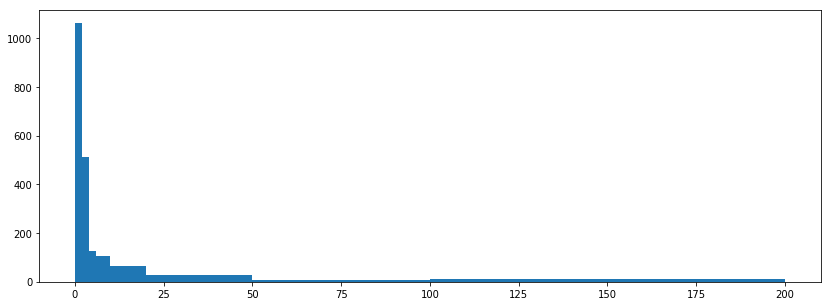

In [78]:
graphs = list(nx.connected_component_subgraphs(graph_main))
plt.figure(figsize=(14,5))
plt.hist([len(x.nodes) for x in graphs], [0,2,4,6,10,20,50,100,200])

In [79]:
filename = PATH_OUTPUT + 'MS_Spec2Vec_graph_08_splitting_dilation.graphml'

# Export graph for drawing (e.g. using Cytoscape)
nx.write_graphml(graph_main, filename)
print("Network stored as graphml file under: ", filename)

Network stored as graphml file under:  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Spec2Vec\output_plots\MS_Spec2Vec_graph_08_splitting_dilation.graphml


In [92]:
#cm = plt.cm.get_cmap('gray')
def plot_cluster(G):
    if len(G.nodes) > 1:

        edges = [(u, v) for (u, v, d) in G.edges(data=True) ]
        weights = [d['weight'] for (u, v, d) in G.edges(data=True) ]
        weights = weights - 0.95*np.min(weights)
        weights = weights/np.max(weights)

        pos = nx.spring_layout(G)  # positions for all nodes
        plt.figure(figsize=(12,12))
        # nodes
        nx.draw_networkx_nodes(G, pos, node_size=100)

        # edges
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=4*weights, alpha=0.5)

        # labels
        nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')

        plt.axis('off')
        plt.show()
    else:
        print("graph not big enough")

In [96]:
# get similarity matrix
from scipy import spatial

M_sim_ctr = 1 - spatial.distance.cdist(MS_library.vectors_centroid, MS_library.vectors_centroid, 'cosine')

In [98]:
graph = graphs[3]
print(len(graph.nodes))

512


In [127]:
min_weight = 0.6
weights_select = np.where(weights >= min_weight)[0]
weights_select

array([  1,   7,   8,  39,  40,  41,  44,  80, 101, 176, 242, 244, 251,
       257, 263, 275, 280, 320, 347, 348, 349, 350, 351, 352, 353, 354,
       355, 356, 357, 358, 359, 360, 361, 365, 366, 367, 370, 373, 374,
       375, 376, 377, 378, 379, 381, 384, 385, 387, 388, 391, 396, 397,
       400, 402, 403, 405, 406, 407, 408, 410, 411, 412, 413, 414, 415,
       416, 417, 423, 429, 449, 450, 451, 491, 497, 498, 502, 503, 504,
       505], dtype=int64)

In [115]:
nodes = list(graph.nodes)
node = nodes[2]
weights = M_sim_ctr[node, [x for x in nodes if x != node]]
len(weights)

511

In [140]:
def add_intra_cluster_links(graph_main,
                           M_sim, 
                           min_weight = 0.5,
                           max_links = 20):
    """ Add links within each separate cluster if weights above min_weight.
    
    Args:
    -------
    """
    # Split graph into separate clusters
    graphs = list(nx.connected_component_subgraphs(graph_main))    
    
    for graph in graphs:
        nodes = list(graph.nodes)
        nodes0 = nodes.copy()
        for node in nodes:
            del nodes0[0]
            weights = M_sim[node, nodes0]
            weights_select = np.where(weights >= min_weight)[0][:max_links]
            new_edges = [(node, nodes0[x], weights[x]) for x in weights_select]
            
            graph_main.add_weighted_edges_from(new_edges)
            
    return graph_main
            

In [141]:
graph_main2 = graph_main.copy()

graph_main2 = add_intra_cluster_links(graph_main2,
                                       M_sim_ctr, 
                                       min_weight = 0.6)

(array([1062.,  511.,  126.,  107.,   63.,   28.,    7.,   11.]),
 array([  0,   2,   4,   6,  10,  20,  50, 100, 200]),
 <a list of 8 Patch objects>)

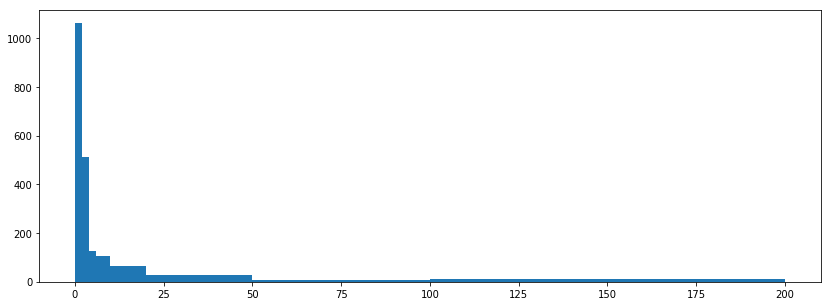

In [142]:
graphs = list(nx.connected_component_subgraphs(graph_main2))
plt.figure(figsize=(14,5))
plt.hist([len(x.nodes) for x in graphs], [0,2,4,6,10,20,50,100,200])

In [135]:
#graphs2 = list(nx.connected_component_subgraphs(MSnet_test))
print([(i, len(x.nodes)) for i, x in enumerate(graphs) if len(x.nodes) > 5])

[(1, 2908), (3, 512), (9, 10), (12, 69), (13, 117), (14, 9), (16, 6), (18, 6), (19, 42), (20, 15), (24, 111), (26, 31), (27, 98), (28, 102), (29, 13), (30, 8), (35, 8), (38, 10), (39, 8), (42, 9), (46, 15), (50, 148), (53, 106), (56, 7), (58, 18), (60, 8), (61, 22), (63, 10), (65, 16), (66, 17), (68, 25), (69, 10), (71, 6), (75, 92), (76, 8), (78, 13), (79, 7), (80, 15), (81, 46), (84, 15), (85, 12), (86, 10), (90, 10), (97, 13), (106, 71), (113, 12), (114, 8), (120, 8), (123, 7), (124, 6), (125, 16), (126, 49), (127, 6), (131, 37), (135, 8), (136, 13), (137, 101), (142, 6), (147, 35), (148, 35), (157, 93), (158, 11), (162, 16), (165, 21), (176, 11), (177, 29), (189, 15), (190, 10), (194, 11), (196, 8), (197, 10), (199, 10), (204, 19), (205, 34), (207, 45), (211, 17), (212, 457), (229, 8), (230, 24), (231, 13), (237, 12), (249, 9), (254, 13), (256, 6), (262, 8), (265, 6), (266, 44), (270, 19), (282, 73), (286, 7), (290, 12), (291, 7), (293, 6), (297, 30), (299, 6), (309, 38), (312, 6),

In [138]:
filename = PATH_OUTPUT + 'MS_Spec2Vec_graph_test.graphml'

# Export graph for drawing (e.g. using Cytoscape)
nx.write_graphml(graphs[13], filename)
print("Network stored as graphml file under: ", filename)

Network stored as graphml file under:  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Spec2Vec\output_plots\MS_Spec2Vec_graph_test.graphml


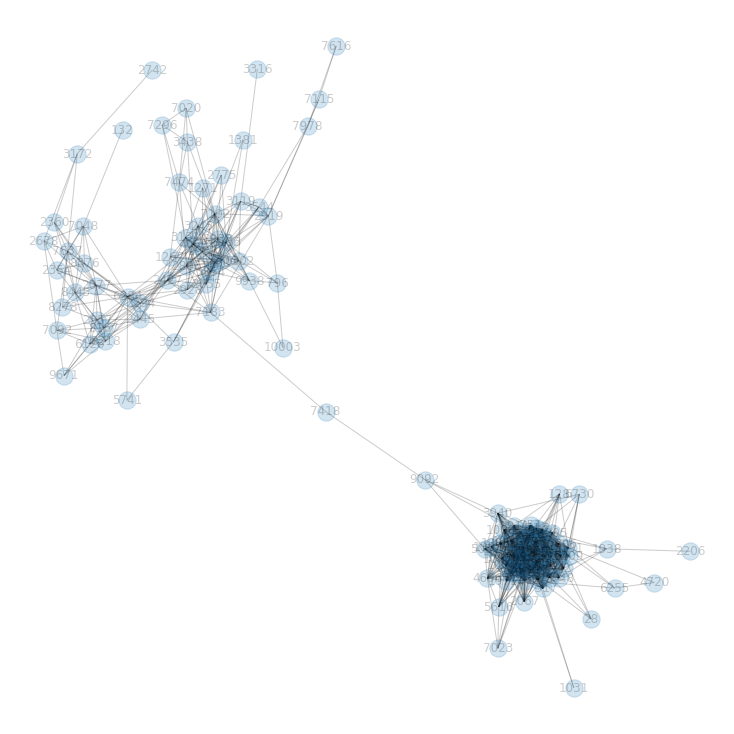

In [144]:
plt.figure(figsize=(10,10))
nx.draw(graphs[13], markersize=5, alpha=0.2, with_labels = True)

In [143]:
plot_cluster(graphs[13])

KeyError: 'weight'

In [137]:
graphs2 = list(nx.connected_component_subgraphs(graph_main))
plot_cluster(graphs2[13])

KeyError: 'weight'

(array([0.000e+00, 4.541e+03, 7.100e+01, 3.300e+01, 1.000e+00]),
 array([  0,   1,   5,  10,  50, 100]),
 <a list of 5 Patch objects>)

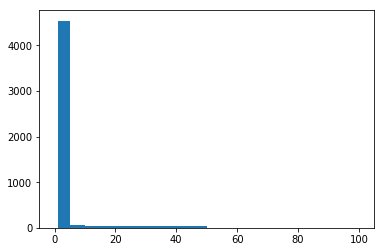

In [751]:
plt.hist([len(x.nodes) for x in graphs], [0,1,5, 10,50,100])

In [712]:
graphs_refined = refine_network(graphs,
                               weigh_bounds = (0.6, 1),
                               max_cluster_size = 100,
                               min_cluster_size = 10,
                               max_search_steps = 1000,
                               max_cuts = 2,
                               max_split_iterations = 2,
                               basic_spliting = True,
                               dilation = False)

------------------------------------------------------------
Splitting iteration: 1 Max cluster size = 735 

Removed 1 edge: [10471 10474]
Getting from cluster with 735 nodes, to clusters with [712, 23] nodes.
Removed 1 edge: [1298 1715]
Getting from cluster with 712 nodes, to clusters with [702, 10] nodes.
Removed 2 edges: [5936 6448 6382 6490]
Getting from cluster with 702 nodes, to clusters with [528, 174] nodes.
Removed 2 edges: [5470 5590 5590 6142]
Getting from cluster with 528 nodes, to clusters with [480, 48] nodes.
Removed 2 edges: [4935 6948 5626 6948]
Getting from cluster with 480 nodes, to clusters with [41, 439] nodes.
Removed 2 edges: [5024 5744 6017 6275]
Getting from cluster with 439 nodes, to clusters with [428, 11] nodes.
Removed 2 edges: [5407 6491 6485 6791]
Getting from cluster with 428 nodes, to clusters with [418, 10] nodes.
Removed 2 edges: [6107 6316 6107 6457]
Getting from cluster with 418 nodes, to clusters with [408, 10] nodes.
Removed 1 edge: [1356 2221]
Ge

NameError: name 'basic_splitting' is not defined

(array([0.000e+00, 6.401e+03, 5.100e+01, 5.000e+00, 2.000e+00]),
 array([  0,   1,  10,  50, 100, 200]),
 <a list of 5 Patch objects>)

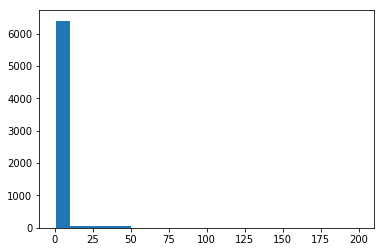

In [718]:
plt.hist([len(x.nodes) for x in graphs], [0,1,10,50,100,200])

In [ ]:
plt.hist([len(x.nodes) for x in graphs_refined])

In [546]:
M_dist = 1- M_sim_ctr
for i in range(M_dist.shape[0]):
    M_dist[i,i] = 0
    
M_dist[M_dist<0] = 0
M_dist = M_dist/np.max(M_dist)

In [547]:
np.min(M_dist), np.mean(M_dist), np.max(M_dist)

(0.0, 0.5116815519874571, 1.0)

In [550]:
import scipy.spatial.distance as ssd

distVec = ssd.squareform(M_dist[:500,:500])

In [554]:
linkage[:10]

array([[4.00000000e+00, 2.43000000e+02, 8.61396392e-02, 2.00000000e+00],
       [3.12000000e+02, 5.00000000e+02, 9.28116435e-02, 3.00000000e+00],
       [2.92000000e+02, 5.01000000e+02, 9.55188744e-02, 4.00000000e+00],
       [3.43000000e+02, 5.02000000e+02, 9.67899990e-02, 5.00000000e+00],
       [1.06000000e+02, 3.52000000e+02, 9.69088514e-02, 2.00000000e+00],
       [3.83000000e+02, 5.03000000e+02, 9.69691862e-02, 6.00000000e+00],
       [5.04000000e+02, 5.05000000e+02, 9.70582909e-02, 8.00000000e+00],
       [3.16000000e+02, 5.06000000e+02, 1.00366285e-01, 9.00000000e+00],
       [3.21000000e+02, 5.07000000e+02, 1.02829122e-01, 1.00000000e+01],
       [2.99000000e+02, 5.08000000e+02, 1.09350422e-01, 1.10000000e+01]])

In [28]:
MSnet.edge_subgraph

EdgeView([(0, 398), (1, 9), (1, 6137), (1, 4837), (1, 1432), (1, 5865), (1, 6391), (1, 1531), (1, 6938), (1, 5856), (1, 196), (1, 2164), (1, 2167), (1, 2589), (2, 11), (2, 10528), (2, 10526), (2, 6480), (2, 8), (2, 6008), (2, 5702), (2, 6009), (2, 6700), (3, 321), (3, 4), (3, 485), (3, 650), (3, 344), (3, 374), (3, 555), (3, 415), (3, 1932), (4, 1932), (4, 1931), (4, 1933), (4, 1930), (4, 292), (4, 340), (4, 352), (4, 285), (4, 383), (5, 14), (5, 17), (5, 8168), (5, 9955), (5, 1039), (5, 9538), (5, 8961), (5, 928), (5, 12), (5, 13), (5, 67), (5, 1180), (5, 2031), (5, 5633), (5, 6706), (5, 8040), (5, 8045), (5, 8707), (5, 8928), (5, 9070), (5, 9166), (5, 9167), (5, 9461), (6, 8038), (6, 8033), (6, 1958), (6, 928), (6, 9016), (6, 8034), (6, 905), (6, 17), (6, 1755), (6, 10790), (7, 6756), (7, 2789), (7, 5659), (7, 5654), (7, 5645), (7, 1397), (7, 5266), (7, 10821), (8, 10528), (8, 3880), (8, 6700), (8, 10526), (8, 6973), (8, 5605), (8, 6442), (8, 2163), (8, 11), (8, 2165), (9, 1432), (9,

In [36]:
Gc = max(nx.connected_component_subgraphs(MSnet), key=len)

In [72]:
print(nx.node_connected_component(MSnet, 5)) 

{8704, 8961, 1281, 8707, 9984, 5, 9731, 9862, 6405, 905, 5253, 907, 12, 13, 14, 1039, 908, 17, 4750, 3986, 1036, 2197, 9750, 23, 151, 1303, 282, 2198, 2574, 27, 928, 9633, 932, 10285, 4910, 9007, 2353, 7601, 9016, 7484, 4928, 9538, 67, 1988, 3601, 9166, 79, 9167, 81, 1752, 9050, 1755, 1754, 8417, 8033, 9955, 8034, 994, 10086, 8038, 8168, 2024, 8174, 2031, 9967, 1010, 8949, 889}


In [62]:
print(nx.triangles(MSnet,5))

31


In [99]:
print(nx.triangles(graphs[4]))

{642: 6, 1156: 10, 4: 0, 1158: 58, 1930: 32, 1931: 32, 1932: 10, 1933: 32, 650: 24, 398: 51, 285: 1, 292: 75, 549: 6, 1584: 0, 570: 34, 321: 0, 581: 1, 1356: 0, 591: 6, 592: 6, 340: 64, 343: 48, 344: 0, 348: 37, 352: 68, 368: 3, 627: 30, 376: 40, 637: 6, 383: 52}


In [98]:
checks = nx.minimum_edge_cut(graphs[4])
checks

{(321, 1933)}

In [88]:
MSnet[79]

AtlasView({23: {'weight': 0.9374692342269866}, 928: {'weight': 0.928017400899956}, 9955: {'weight': 0.9228089363421861}, 9050: {'weight': 0.9223641487700928}, 9016: {'weight': 0.9220000826367285}, 8961: {'weight': 0.9172047174780669}, 2024: {'weight': 0.9169655328632225}, 908: {'weight': 0.9159440901594007}, 9538: {'weight': 0.9153876380055741}, 81: {'weight': 0.9059722900354199}, 282: {'weight': 0.9039079073243937}, 932: {'weight': 0.9147859953609981}, 9166: {'weight': 0.9007636573575837}})

In [103]:
nodes = list(graphs[4].nodes)
print(nodes)

[642, 1156, 4, 1158, 1930, 1931, 1932, 1933, 650, 398, 285, 292, 549, 1584, 570, 321, 581, 1356, 591, 592, 340, 343, 344, 348, 352, 368, 627, 376, 637, 383]


In [111]:
import numpy as np
np.random.choice(nodes,2, replace=False)


376

# Removing links:
## Find single links that are connecting (sub)clusters

In [178]:
a = np.array(graphs[4].nodes)
new_array = np.array(np.meshgrid(a,a)).T
remove_diagonal = np.array([(i*new_array.shape[0] + i) for i in range(new_array.shape[0])])
#new_array =new_array.reshape(-1,2)
new_array = np.delete(new_array.reshape(-1,2), remove_diagonal, axis=0)
new_array

array([[ 642, 1156],
       [ 642,    4],
       [ 642, 1158],
       ...,
       [ 383,  627],
       [ 383,  376],
       [ 383,  637]])

In [183]:
choices = np.random.choice(np.arange(new_array.shape[0]), 10, replace=False)
choices

array([293, 768, 659, 687, 521,  31, 392,  82, 424, 114])

In [185]:
test = new_array[choices,:]
for t in test:
    print(t)

[ 285 1158]
[627 570]
[344 343]
[348 340]
[1356  383]
[1156 1158]
[1584  581]
[  4 368]
[570 592]
[1158  637]


In [569]:
min_size_after_cutting = [8,2,1, 15, 50, 120, 1]
np.argmax(min_size_after_cutting)

5

In [573]:
[(i, len(x.nodes)) for i, x in enumerate(graphs) if len(x.nodes) > 10][:10]

[(1, 735),
 (4, 353),
 (5, 296),
 (9, 68),
 (24, 19),
 (34, 33),
 (106, 26),
 (749, 90),
 (787, 14),
 (902, 17)]

In [575]:
graphs[0].nodes

NodeView((0,))

In [651]:
graph_split = split_cluster(graphs[:4],
                     max_cluster_size = 100,
                     min_cluster_size = 10,
                     max_search_steps = 1000,
                     max_cuts = 2)

[23, 10, 8, 6, 3, 7, 7, 2, 1, 1, 4, 4, 2, 2, 6, 2, 1, 2, 4, 1, 6, 1, 15, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 22, 1, 1, 1, 16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0
Removed 1 edge: [10471 10474]
Getting from cluster with 735 nodes, to clusters with [712, 23] nodes.
[10, 8, 6, 3, 7, 7, 2, 1, 1, 4, 4, 2, 2, 6, 2, 1, 2, 4, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0
Removed 1 edge: [1298 1715]
Getting from cluster with 712 nodes, to clusters with [702, 10] nodes.
[174, 48, 41, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 2, 1, 10, 1, 1, 2]
0
Removed 2 edges: [5936 6448 6382 6490]
Getting from cluster with 702 nodes, to clusters with [528, 174] nodes.
[48, 41, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1

In [652]:
[(i, len(x.nodes)) for i, x in enumerate(graph_split) if len(x.nodes) > 0]

[(0, 1),
 (1, 23),
 (2, 10),
 (3, 174),
 (4, 48),
 (5, 41),
 (6, 10),
 (7, 10),
 (8, 419),
 (9, 2),
 (10, 1)]

In [684]:
weights

array([0.92611898, 1.        , 0.96359109, 0.91983064, 0.79999883,
       0.86775257, 0.6722236 , 0.78019573, 0.68187561, 0.69372037,
       0.8299046 , 0.78421837, 0.7381374 , 0.83808504, 0.78569548])

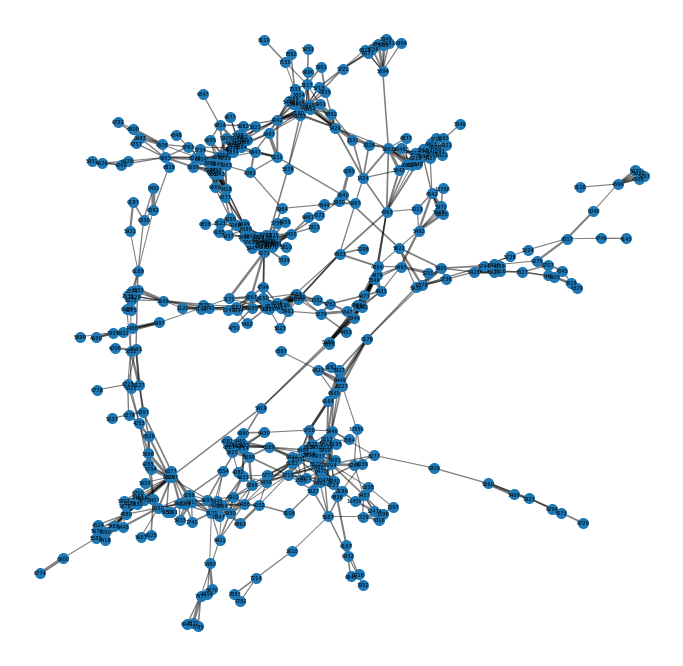

In [703]:
cm = plt.cm.get_cmap('gray')

G = graph_split[8]
edges = [(u, v) for (u, v, d) in G.edges(data=True) ]
weights = [d['weight'] for (u, v, d) in G.edges(data=True) ]
weights = weights - 0.95*np.min(weights)
weights = weights/np.max(weights)

pos = nx.spring_layout(G)  # positions for all nodes
plt.figure(figsize=(12,12))
# nodes
nx.draw_networkx_nodes(G, pos, node_size=100)

# edges
nx.draw_networkx_edges(G, pos, edgelist=edges, width=4*weights, alpha=0.5)

# labels
nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')

plt.axis('off')
plt.show()

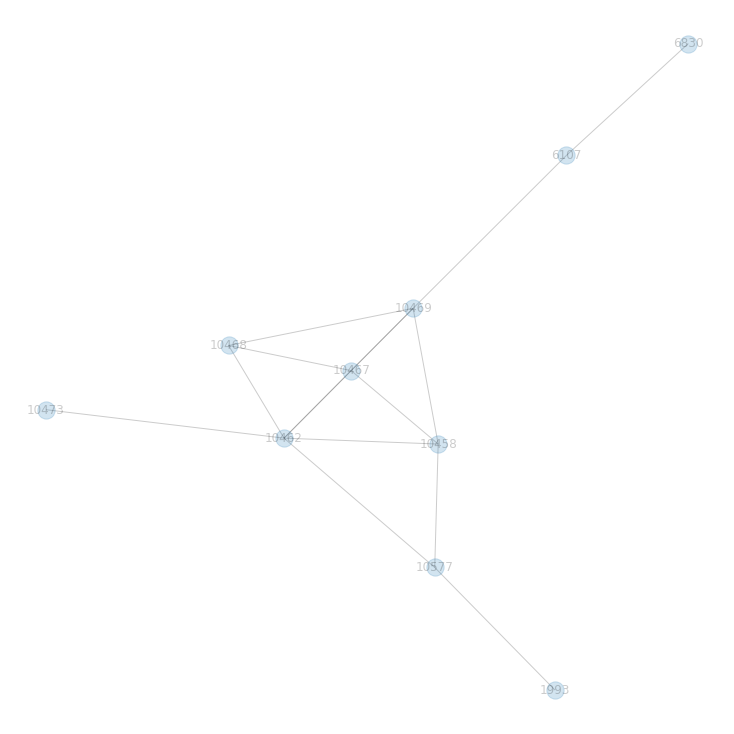

In [660]:
plt.figure(figsize=(10,10))
nx.draw(graph_split[7], markersize=5, alpha=0.2, with_labels = True)

In [597]:
weak_links = weak_link_finder(graphs[1],
                     max_steps = 1000,
                     max_cuts = 4)

weak_links

[(1, array([[ 5891,  6603],
         [ 5894,  6994],
         [ 6411,  7477],
         [ 6926,  8277],
         [10254, 10286],
         [ 4880,  5671],
         [ 1298,  1715],
         [ 6163,  6690],
         [ 1300,  1302],
         [ 5653,  6109],
         [ 6167,  6836],
         [ 2587,  6431],
         [ 5660,  6926],
         [ 5407,  6025],
         [10280, 10368],
         [ 3117,  5053],
         [ 7214,  7883],
         [ 2610,  5587],
         [10546, 10636],
         [ 5687,  6050],
         [ 3905,  5899],
         [ 6213,  6836],
         [ 6727,  6937],
         [ 6728,  6778],
         [ 5705,  6910],
         [ 5964,  6544],
         [ 5455,  6461],
         [ 6484,  8371],
         [ 3673,  6729],
         [ 5728,  5744],
         [ 2913,  5455],
         [ 3171,  5480],
         [ 4453,  5279],
         [10604, 10610],
         [10604, 10673],
         [10350, 10356],
         [ 3952,  6952],
         [ 6774,  6900],
         [ 7033,  7892],
         [ 6016,  6167

In [607]:
pairs_already_removed = []

for i, pair in enumerate(pairs):
    for node in pair:
        if node not in list(subgraphs[0].nodes):
            pairs_already_removed.append(i)
    pairs_already_removed = list(set(pairs_already_removed)) 
    
pairs_already_removed

[0, 1]

In [648]:
max_cluster_size = 300
min_cluster_size = 10
max_search_steps = 1000
max_cuts = 2
multiple_cuts_per_level = True

new_graphs = []
graph = graphs[1].copy()


split_done = False
j = 0
new_graph = graph.copy()
while not split_done and j < len(weak_links):

    # Test best candidates
     
    new_graph_testing = new_graph.copy()
    pairs = weak_links[j][1]
    pair_counts = weak_links[j][2] 
    pairs = pairs[pair_counts.argsort()[::-1]]
    #print(i,j, pairs)

    # Check if pairs have already been removed in former iteration
    pairs_still_present = []
    for i, pair in enumerate(pairs):
        all_edges_present = True
        for m in range(int(pairs.shape[1]/2)):
            edge = (pair[m*2], pair[m*2+1])
            if edge not in new_graph_testing.edges:
                all_edges_present = False             
        if all_edges_present:
            pairs_still_present.append(i)          
        pairs_still_present = list(set(pairs_still_present))     
    pairs = pairs[pairs_still_present] # Remove pairs which have been cut out already
        
    # Test removing proposed links for all pairs
    min_size_after_cutting = []
    for pair in pairs:
        new_graph_testing = new_graph.copy()

        # Remove edges in pair
        for m in range(int(pairs.shape[1]/2)):
            new_graph_testing.remove_edge(pair[m*2], pair[m*2+1])

        # Check if created subclustes are big enough:
        subgraphs = list(nx.connected_component_subgraphs(new_graph_testing))
        min_size_after_cutting.append(min([len(x.nodes) for x in subgraphs]))

    # Select best partition of graph (creating most similar sized subclusters)
    best_partition = np.argmax(min_size_after_cutting)
    print(min_size_after_cutting)
    print(best_partition)
    if min_size_after_cutting[best_partition] >= min_cluster_size:
        new_graph_testing = new_graph.copy()
        pair = pairs[best_partition]
        # Remove edges in selected pair
        for m in range(int(pairs.shape[1]/2)):
            new_graph_testing.remove_edge(pair[m*2], pair[m*2+1])
        subgraphs = list(nx.connected_component_subgraphs(new_graph_testing))
        
        if int(pairs.shape[1]/2) > 1:
            print("Removed", int(pairs.shape[1]/2), "edges:", pair)
        else:
            print("Removed", int(pairs.shape[1]/2), "edge:", pair)
        print("Getting from cluster with", len(new_graph.nodes), "nodes, to clusters with",
             [len(x.nodes) for x in subgraphs], "nodes.")
        idx1 = np.argmax([len(x.nodes) for x in subgraphs])
        idx2 = [x for x in range(len(subgraphs)) if x != idx1]
        new_graph = subgraphs[idx1] # keep largest subcluster here
        new_graphs.extend([subgraphs[int(x)] for x in idx2])
        
        if len(new_graph.nodes) <= max_cluster_size:
            split_done = True
        else:
            pass
    
    # Check if more suited cuts to expect at the same level (num of cuts necessary)
    idx = np.argsort(min_size_after_cutting)[::-1][1]
    if min_size_after_cutting[idx] >= min_cluster_size and multiple_cuts_per_level:
        pass
    else:
        j += 1

[10, 23, 6, 4, 15, 7, 8, 6, 1, 7, 1, 4, 6, 2, 2, 1, 1, 1, 4, 5, 1, 1, 3, 20, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 21, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 22, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 16, 1, 1, 1, 2]
1
Removed 1 edge: [10471 10474]
Getting from cluster with 735 nodes, to clusters with [712, 23] nodes.
[10, 6, 4, 7, 8, 6, 1, 7, 1, 4, 6, 2, 2, 1, 1, 1, 4, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
0
Removed 1 edge: [1298 1715]
Getting from cluster with 712 nodes, to clusters with [702, 10] nodes.
[174, 48, 41, 10, 1, 1, 1, 4, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 11, 1, 10, 2, 1, 1, 1, 1, 1, 2, 2]
0
Removed 2 edges: [5936 6448 6382 6490]
Getting from cluster with 702 nodes, to clusters with [528, 174] nodes.
[48, 41, 10, 1, 1, 1, 4, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [646]:
idx = np.argsort(min_size_after_cutting)[::-1][1]
print(idx)
min_size_after_cutting[idx]

20


59

In [645]:
min_size_after_cutting

[6, 1, 2, 1, 1, 1, 1, 1, 2, 1, 7, 1, 42, 1, 1, 1, 1, 1, 1, 60, 59, 1]

In [632]:
pairs_still_present = []
for i, pair in enumerate(pairs):
    for m in range(int(pairs.shape[1]/2)):
        edge = (pair[m*2], pair[m*2+1])
    #for node in pair:
        all_edges_present = True
        if edge not in new_graph_testing.edges:
            all_edges_present = False
        if all_edges_present:
            pairs_still_present.append(i)

    pairs_still_present = list(set(pairs_still_present)) 
pairs_still_present, len(pairs_still_present)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45],
 45)

In [628]:
pairs

array([[ 5936,  6448,  6382,  6490],
       [ 5470,  5590,  5590,  6142],
       [ 4935,  6948,  5626,  6948],
       [ 5407,  6491,  6485,  6791],
       [    1,     9,     9,  1432],
       [ 5623,  5961,  5623,  6254],
       [ 5462,  5994,  5462,  6151],
       [ 4269,  5903,  5903,  6629],
       [ 6457, 10474, 10459, 10474],
       [ 5964,  6271,  5964,  6381],
       [ 5457,  5821,  5758,  5821],
       [ 5921,  6197,  6197,  6330],
       [ 5971, 10758,  6542, 10758],
       [ 3830,  6876,  4459,  6876],
       [ 2584,  5946,  2584,  6419],
       [ 4524,  4880,  4524,  5590],
       [ 1597,  1598,  1597,  6308],
       [ 4418,  4880,  4418,  5589],
       [ 5819,  6222,  5819,  6769],
       [ 5450,  6330,  5450,  6592],
       [  186,   189,   189,  6431],
       [ 5812,  6006,  6006,  6591],
       [ 5812,  6188,  6188,  6189],
       [ 3117,  7155,  7033,  7155],
       [ 6032,  6863,  6216,  6863],
       [ 3117,  3661,  3661,  6935],
       [ 5927,  6291,  6227,  6291],
 

In [625]:
new_graph_testing.edges

EdgeView([(1, 9), (1, 6137), (1, 4837), (1, 1432), (1, 5865), (6150, 3687), (6150, 4484), (6150, 5171), (6150, 5961), (6150, 5994), (6150, 6826), (6150, 6254), (6150, 6467), (6150, 6667), (6150, 6271), (6150, 6199), (6151, 4366), (6151, 4794), (6151, 5462), (6151, 6085), (6151, 6089), (6151, 6667), (6151, 6467), (9, 1432), (6159, 2741), (6159, 5554), (6159, 5917), (6159, 5933), (6159, 6050), (6159, 6377), (6163, 2389), (6163, 2398), (6163, 3117), (6163, 4042), (6163, 5428), (6163, 5429), (6163, 5446), (6163, 5578), (6163, 5686), (6163, 5718), (6163, 5721), (6163, 5804), (6163, 5901), (6163, 6083), (6163, 6414), (6163, 7033), (6163, 6190), (6163, 6690), (6164, 5706), (6164, 5927), (6164, 6865), (6164, 6213), (6164, 6449), (6164, 6227), (6167, 6016), (6167, 6836), (6167, 6848), (6178, 5630), (6178, 5927), (6178, 6449), (6178, 6227), (6178, 6865), (6178, 6378), (6181, 5568), (6181, 5738), (6181, 5849), (6181, 5894), (6181, 6842), (6183, 2586), (6183, 2825), (6183, 3735), (6183, 5456), (61

In [465]:
weak_links = weak_link_finder(graphs[4],
                     #max_cluster_size = 300,
                     #min_cut_size = 10,
                     max_steps = 1000,
                     max_cuts = 4)

weak_links

[(1, array([[   4, 1932],
         [ 321,  344],
         [ 321, 1933],
         [ 637, 1584],
         [ 637, 1356],
         [ 637, 1156]]), array([ 49,  30,  68,  34,  34, 255], dtype=int64)),
 (2, array([[285, 292, 285, 348],
         [398, 581, 581, 650]]), array([37, 37], dtype=int64)),
 (3, array([[292, 368, 343, 368, 368, 383]]), array([34], dtype=int64)),
 (4, array([[549, 591, 549, 592, 549, 637, 549, 642],
         [549, 591, 591, 592, 591, 637, 591, 642],
         [549, 592, 591, 592, 592, 637, 592, 642],
         [549, 637, 591, 637, 592, 637, 637, 642],
         [549, 642, 591, 642, 592, 642, 637, 642]]), array([4, 4, 4, 4, 4], dtype=int64))]

In [479]:
pairs.shape[1]

2

In [503]:
j = 1

idx = weak_links[j][2].argsort()[::-1]
pairs = weak_links[j][1][idx]
print(pairs)
for pair in pairs:
    for m in range(int(pairs.shape[1]/2)):
        print(m)
        print(pair[m*2], pair[m*2+1])

[[398 581 581 650]
 [285 292 285 348]]
0
398 581
1
581 650
0
285 292
1
285 348


In [516]:
nx.conductance(graphs[6614],8784, 8879)

TypeError: argument of type 'int' is not iterable

[8784 8879]


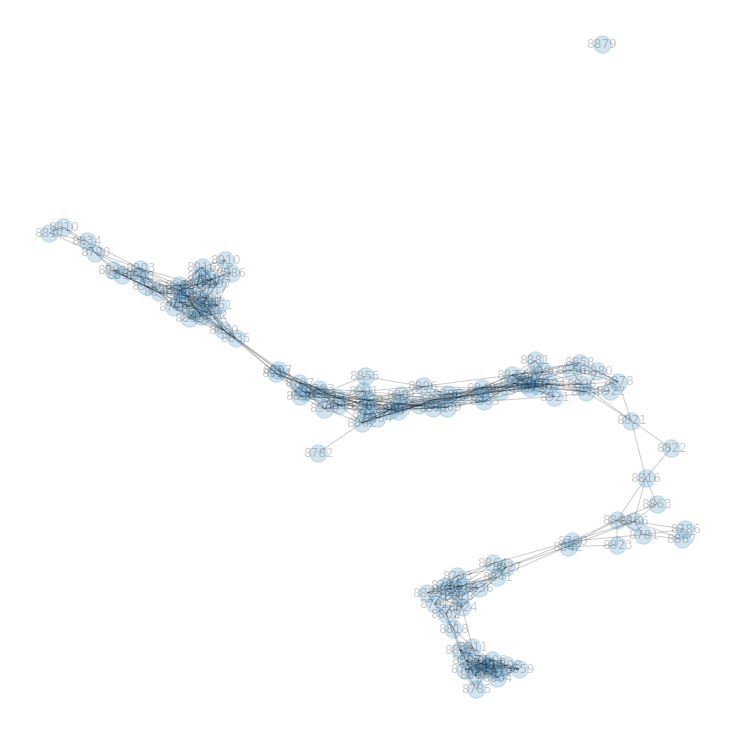

In [442]:
new_graph = graphs[6614].copy()
#for a in weak_links[0][2]:
    #print(a)
    #new_graph.remove_edge(a[0], a[1])
a = weak_links[0][2]
for i in range(int(len(a)/2)):
    print(a)
    new_graph.remove_edge(a[i*2], a[i*2+1])
plt.figure(figsize=(10,10))
nx.draw(new_graph, markersize=5, alpha=0.2, with_labels = True)

In [445]:
subgraphs = list(nx.connected_component_subgraphs(new_graph))
min([len(x.nodes) for x in subgraphs])

1

In [369]:
id_max = np.argmax([x[1] for x in weak_links])
weak_links[id_max][2]

array([[9007, 9967]])

In [412]:
sampled_cuts = sample_cuts(graphs[1405],
                                max_steps = 1000,
                                max_cuts = 4)


In [415]:
min_cuts = 1
sampled_cuts_select = [list(x)[:min_cuts] for x in sampled_cuts if len(x) == min_cuts]
sampled_cuts_select = np.array(sampled_cuts_select)
# Sort array
if min_cuts > 1:
    sampled_cuts_select = np.sort(np.sort(sampled_cuts_select, axis=2), axis=1)
else:
    sampled_cuts_select = np.sort(sampled_cuts_select, axis=2) 

cuts_unique, cuts_count = row_counts(sampled_cuts_select.reshape(-1,min_cuts*2))

In [416]:
cuts_unique, cuts_count

(array([[ 5643,  6222],
        [ 5643,  6490],
        [ 4620,  4960],
        [ 5395,  5396],
        [ 5405,  5972],
        [ 5405,  6521],
        [ 5405,  5817],
        [ 4656,  6769],
        [ 5211,  5562],
        [ 5725,  6769],
        [ 4191,  5817],
        [ 5499,  6965],
        [ 5499,  5795],
        [ 6021,  6782],
        [ 5817,  6642],
        [ 6140, 10533]]),
 array([ 10,  17,  15,  17,   6,   8,  52,   8,   9,  20,   6,  22,   8,
        107,  10,  17], dtype=int64))

In [295]:
my_array = test.reshape(-1,4)

dt = np.dtype((np.void, my_array.dtype.itemsize * my_array.shape[1]))
b = np.ascontiguousarray(my_array).view(dt)
unq, cnt = np.unique(b, return_counts=True)
unq = unq.view(my_array.dtype).reshape(-1, my_array.shape[1])
unq, cnt


(array([[285, 292, 285, 348],
        [398, 581, 581, 650]]), array([37, 37], dtype=int64))

In [139]:
# find most frequent element in a list 
def most_frequent(List): 
    return max(set(List), key = List.count) 


In [140]:
test1 = [list(x)[0] for x in test]

test_sorted = []
for (x,y) in test1:
    #x,y = test
    if x > y:
        test_sorted += [(y,x)]
    else:
        test_sorted += [(x,y)]    
        
most_frequent(test_sorted)

(637, 1156)

In [105]:
nx.minimum_edge_cut(graphs[4],nodes[0], 592)#nodes[1])

{(549, 592), (591, 592), (637, 592), (642, 592)}

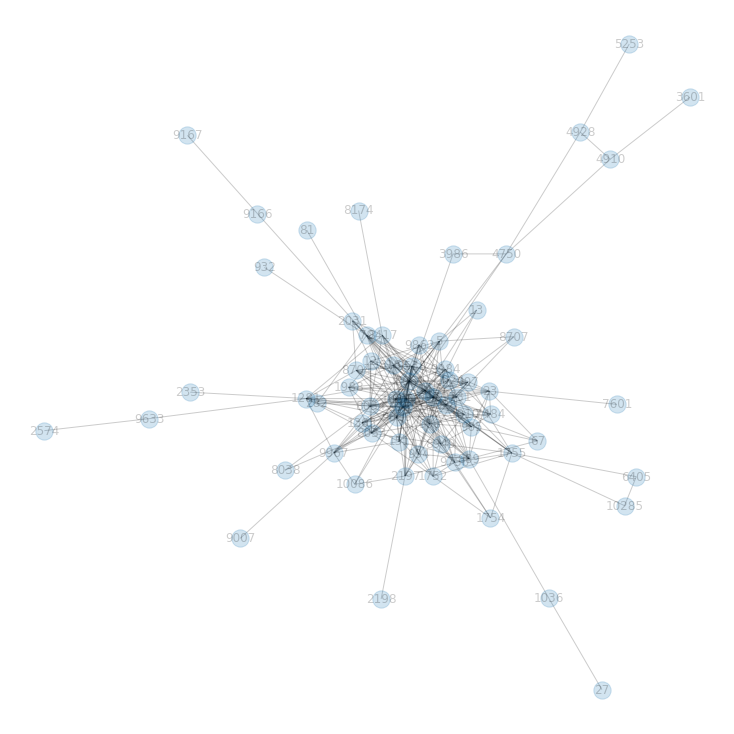

In [368]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
nx.draw(graphs[5], markersize=5, alpha=0.2, with_labels = True)

In [141]:
cutsets = list(nx.all_node_cuts(graphs[4]))
cutsets

[{1933}, {637}, {1156}, {1932}, {321}]

In [142]:
connectivities = nx.all_pairs_node_connectivity(graphs[4])

In [150]:
connectivities[642]

{1156: 1,
 4: 1,
 1158: 1,
 1930: 1,
 1931: 1,
 1932: 1,
 1933: 1,
 650: 1,
 398: 1,
 285: 1,
 292: 1,
 549: 4,
 1584: 1,
 570: 1,
 321: 1,
 581: 1,
 1356: 1,
 591: 4,
 592: 4,
 340: 1,
 343: 1,
 344: 1,
 348: 1,
 352: 1,
 368: 1,
 627: 1,
 376: 1,
 637: 4,
 383: 1}